# LSTM + Conv2D 模型结构

## 1. 输入数据
- **形状**: (Batch, Time, Features, 1)
- 在进入卷积层前，重塑为 (Batch, 1, Time, Features)，以匹配 Conv2D 输入格式。

## 2. 卷积前端
1. **卷积块 1 & 2**:
   - 1×2 Conv2D（融合相邻价量特征）
   - 4×1 Conv2D（捕捉短期时间模式）
   - LeakyReLU 激活
2. **卷积块 3**:
   - 1×10 Conv2D（聚合全部剩余特征）
   - 4×1 Conv2D
3. **Inception 模块**:
   - 分支 1: 1×1 Conv2D → 3×1 Conv2D
   - 分支 2: 1×1 Conv2D → 5×1 Conv2D
   - 分支 3: MaxPool(3×1) → 1×1 Conv2D
   - 在通道维度拼接，融合多尺度时间信息。

## 3. LSTM 序列处理
- 将 Inception 输出重塑为 (Batch, Time, Channels)。
- 输入单层 LSTM，建模长程依赖。
- 取最后时间步隐藏状态作为序列表示。

## 4. 分类输出头
- Drop


# Transformer + Conv1D 模型结构

## 1. 输入数据
- **形状**: (Batch, Time, Features, 1)
- 在进入卷积层前，重塑为 (Batch, Features, Time)，以匹配 Conv1D 输入格式。

## 2. 卷积前端
1. **卷积块 1**:
   - Conv1D(32, kernel_size=3) → BatchNorm1d → LeakyReLU
2. **卷积块 2**:
   - Conv1D(64, kernel_size=3) → BatchNorm1d → LeakyReLU
   - AvgPool1d(时间维度减半)
3. **1D Inception 模块**:
   - 分支 1: Conv1D(64, kernel_size=3)
   - 分支 2: Conv1D(64, kernel_size=5)
   - 分支 3: MaxPool1d(kernel_size=3) → Conv1D(64, kernel_size=1)
   - 将三个分支的输出在通道维度拼接，得到通道数 192 的特征图。

## 3. Transformer 后端
- 重塑为 (Batch, Time_out, d_model=192)。
- 添加可学习的 **[CLS] Token**。
- 加入正弦/余弦位置编码。
- 堆叠多层 Transformer Encoder，每层包含：
  - 多头自注意力（Multi-Head Self-Attention）
  - 前馈神经网络（Feed-Forward Network）

## 4. 分类输出头
- 取 [CLS] Token 的最终表示。
- Dropout(0.5)
- Linear 输出到 3 类（下降、不变、上升）的 logits。


下载中文字体

已有字体文件: NotoSansCJKsc-Regular.otf
 已启用中文字体： Noto Sans CJK SC


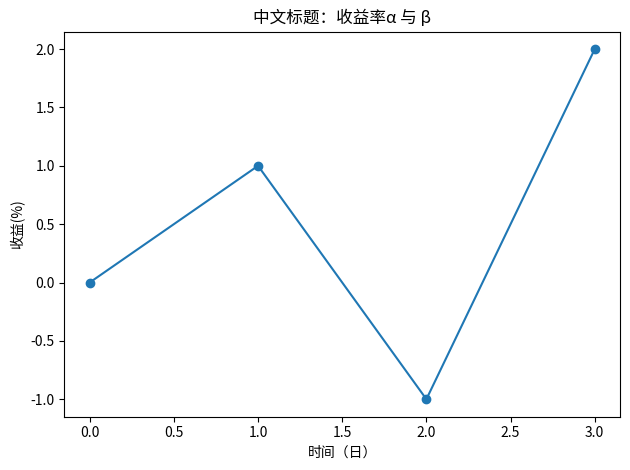

In [ ]:
# === 一次性：下载中文字体 → 注册 → 配置 Matplotlib → 测试中文 ===
import os, sys, time, urllib.request
import matplotlib as mpl
from matplotlib import font_manager
import matplotlib.pyplot as plt

#  备选字体下载地址（按优先级尝试）
CANDIDATES = [
    # Noto Sans CJK SC
    ("NotoSansCJKsc-Regular.otf",
     "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf"),
    ("NotoSansCJKsc-Regular.otf",
     "https://raw.githubusercontent.com/googlefonts/noto-cjk/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf"),
    # Source Han Sans SC (思源黑体)
    ("SourceHanSansSC-Regular.otf",
     "https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/SimplifiedChinese/SourceHanSansSC-Regular.otf"),
]

def try_download(dest, url, timeout=25):
    try:
        print(f"↘︎ 下载: {url}")
        urllib.request.urlretrieve(url, dest)
        # 简单验收：大小>100KB
        if os.path.getsize(dest) < 100 * 1024:
            raise RuntimeError("下载文件异常（过小）")
        print(f"已保存: {dest}  ({os.path.getsize(dest)/1024:.0f} KB)")
        return True
    except Exception as e:
        print(f"下载失败: {e}")
        if os.path.exists(dest):
            try: os.remove(dest)
            except: pass
        return False

# 2) 若本地已存在可用字体，直接用；否则逐个下载尝试
font_path = None
for fname, url in CANDIDATES:
    if os.path.exists(fname):
        font_path = fname
        print(f"已有字体文件: {fname}")
        break
else:
    for fname, url in CANDIDATES:
        if try_download(fname, url):
            font_path = fname
            break

if not font_path:
    raise RuntimeError(" 无法下载中文字体。请检查网络/代理，或手动上传任一 OTF/TTF 后重试。")

# 3) 注册字体并设为默认 sans-serif
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()

mpl.rcParams["font.sans-serif"] = [font_name]
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42
mpl.rcParams["svg.fonttype"] = "none"

print(" 已启用中文字体：", font_name)

# 4) 画一张测试图
plt.figure()
plt.title("中文标题：收益率α 与 β")
plt.xlabel("时间（日）")
plt.ylabel("收益(%)")
plt.plot([0,1,2,3],[0,1,-1,2], marker="o")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import pickle
import re
from typing import List, Union, Tuple


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Replace TensorFlow imports with PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset



设置全局参数，这里我们选择日期

In [ ]:
# 全局参数设置
# 数据日期范围参数
START_DATE = '2024-8-1'  # 数据开始日期
END_DATE = '2024-8-31'    # 数据结束日期

# 期货品种设置
SYMBOL_TYPES = ['IM']  # 暂时不能并行训练

# 类别映射
CLASS_MAPPING = {-1: "下降", 0: "不变", 1: "上升"}
CLASS_LABELS = ["下降", "不变", "上升"]

# 数据处理参数
LOOKBACK_WINDOW = 5  # 用于计算标准化参数的历史天数
TIMESTAMP_PER_SAMPLE = 10  # 每个样本的时间步长
K = 5  # 用于计算未来价格走势的时间步长
ALPHA =4.33163e-05  # 价格变化阈值，用于生成标签

# 数据缓存路径
DATA_CACHE_DIR = "./data_cache"
os.makedirs(DATA_CACHE_DIR, exist_ok=True)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


def get_processed_data(
    start_date: Union[str, np.datetime64, pd.Timestamp],
    end_date: Union[str, np.datetime64, pd.Timestamp] = None,
    symbol_types: List[str] = SYMBOL_TYPES,
    time_range: Tuple[str, str] = None,
    parquet_path: str = '/content/drive/MyDrive/IM00_subset.parquet',
    resample_500ms: bool = True,
    freq: str = "500ms",
    include_session_label: bool = True,
    strict_fixed_bounds: bool = False,   # True 时用固定 09:30/11:30 等边界与真实首尾取交集
) -> pd.DataFrame:
    """
    从本地 Parquet 读取 -> 按日期/标的/交易时段筛选 -> (可选)按 session 内真实首尾时间强制 500ms 对齐并后向填充。
    - 若 time_range 提供，仅对该单一时段对齐；否则默认上午/下午两段。
    - 对齐后 m_time 由网格 Timestamp 重建为 'HHMMSSsss'。
    - 返回列包含 Timestamp、Trade_Date（重命名后）、(可选)Session、以及 L1-L5 价量与 Symbol。
    """
    # 1) 读文件
    try:
        print(f"正在从 '{parquet_path}' 加载数据...")
        df = pd.read_parquet(parquet_path)
        print(f"数据加载成功，共 {len(df)} 条记录。")
    except FileNotFoundError:
        print(f"错误：未找到文件 '{parquet_path}'。请确保文件路径正确。")
        return pd.DataFrame()

    # 2) 处理日期参数
    if end_date is None:
        end_date = start_date
    start_date_for_filter = pd.to_datetime(start_date).strftime('%Y%m%d')
    end_date_for_filter   = pd.to_datetime(end_date).strftime('%Y%m%d')
    print(f"将使用筛选日期范围: {start_date_for_filter} 到 {end_date_for_filter}")

    # 3) 基础字段规范
    for c in ('MDDate', 'MDTime', 'Symbol'):
        if c in df.columns:
            df[c] = df[c].astype(str)

    # 4) 组装 Timestamp（'YYYYMMDD' + 'HHMMSSsss'）
    print("正在高效转换时间戳...")
    datetime_format = '%Y%m%d %H%M%S%f'  # 注意：%f 是微秒，会接收我们拼出来的毫秒后三位 + “000”
    # 将 MDTime 标准化为 9 位（毫秒 3 位），不足左侧补零
    if 'MDTime' in df.columns:
        mt = df['MDTime'].str.replace(r'\D', '', regex=True).str.zfill(9).str[:9]
    else:
        raise KeyError("缺少列 'MDTime'，无法构造 Timestamp")
    df['Timestamp'] = pd.to_datetime(df['MDDate'] + ' ' + mt, format=datetime_format, errors='coerce')
    df.dropna(subset=['Timestamp'], inplace=True)
    df.sort_values('Timestamp', inplace=True)
    print("时间戳转换完成。")

    # 5) 日期与标的筛选
    print(f"正在按日期 ({start_date_for_filter} to {end_date_for_filter}) 和合约类型 ({symbol_types}) 筛选数据...")
    date_mask   = df['MDDate'].between(start_date_for_filter, end_date_for_filter)
    symbol_mask = df['Symbol'].str.strip().str.startswith(tuple(symbol_types))
    result_df   = df[date_mask & symbol_mask].copy()
    if result_df.empty:
        print(f"在 {start_date_for_filter} 到 {end_date_for_filter} 范围内未找到合约类型为 {symbol_types} 的数据。")
        return pd.DataFrame()
    print(f"初步筛选后，找到 {len(result_df)} 条记录。")

    # 6) 交易时段筛选条件
    if time_range is not None:
        sessions = [(pd.to_datetime(time_range[0]).time(), pd.to_datetime(time_range[1]).time())]
    else:
        sessions = [
            (pd.to_datetime("09:30:00").time(), pd.to_datetime("11:30:00").time()),
            (pd.to_datetime("13:00:00").time(), pd.to_datetime("15:00:00").time()),
        ]

    # 7) (可选) 按 session 内真实首尾时间强制 500ms 对齐 + 后向填充
    if resample_500ms:
        orig_cnt = len(result_df)
        out_parts = []
        # 按天处理，避免跨天 asof 污染
        for day, df_day in result_df.groupby(result_df['Timestamp'].dt.date):
            for (t_start, t_end) in sessions:
                mask = (df_day['Timestamp'].dt.time >= t_start) & (df_day['Timestamp'].dt.time <= t_end)
                seg = df_day.loc[mask].drop_duplicates(subset=['Timestamp'], keep='last').sort_values('Timestamp')
                if seg.empty:
                    continue

                # 网格边界：默认真实首尾；开启 strict_fixed_bounds 则与固定边界取交集
                g_start = seg['Timestamp'].iloc[0]
                g_end   = seg['Timestamp'].iloc[-1]
                if strict_fixed_bounds:
                    fixed_start = pd.Timestamp(f"{day} {t_start}")
                    fixed_end   = pd.Timestamp(f"{day} {t_end}")
                    g_start = max(g_start, fixed_start)
                    g_end   = min(g_end,   fixed_end)
                    if g_start >= g_end:
                        continue

                grid = pd.DataFrame({'Timestamp': pd.date_range(start=g_start, end=g_end, freq=freq)})

                # asof 后向填充：对每个网格点拿“<=该时刻”的最后一条真实快照
                aligned = pd.merge_asof(
                    grid, seg.sort_values('Timestamp'),
                    on='Timestamp', direction='backward'
                )

                # 标记 session / 交易日
                if include_session_label:
                    aligned['Session'] = f"{t_start}-{t_end}"
                aligned['TradeDate_tmp'] = pd.Timestamp(day)

                out_parts.append(aligned)

        if not out_parts:
            print("所有所选时段内均无可对齐数据，返回空表。")
            return pd.DataFrame()

        result_df = pd.concat(out_parts, ignore_index=True).sort_values(['TradeDate_tmp', 'Timestamp']).reset_index(drop=True)
        print(f"[resample] 完成 500ms 对齐：输出 {len(result_df)} 行（原始 {orig_cnt} 行）。")
    else:
        # 仅做简单时段筛选（不对齐）：
        time_condition = False
        for (t_start, t_end) in sessions:
            time_condition = time_condition | (
                (result_df['Timestamp'].dt.time >= t_start) & (result_df['Timestamp'].dt.time <= t_end)
            )
        result_df = result_df[time_condition].copy()
        print(f"经过交易时间筛选后，剩余 {len(result_df)} 条记录。")

    # 8) 重建 MDDate / MDTime，随后重命名
    #    - 用网格后的 Timestamp 生成年月日与毫秒时间，避免与原始快照不一致
    result_df['MDDate'] = result_df['Timestamp'].dt.strftime('%Y-%m-%d')
    # 'HHMMSS' + 毫秒 3 位
    result_df['MDTime'] = (
        result_df['Timestamp'].dt.strftime('%H%M%S') +
        (result_df['Timestamp'].dt.microsecond // 1000).astype(str).str.zfill(3)
    )

    rename_map = {
        'MDDate': 'Trade_Date',
        'MDTime': 'm_time',
        'Buy1Price': 'BidPrice1', 'Buy1OrderQty': 'BidVolume1', 'Sell1Price': 'AskPrice1', 'Sell1OrderQty': 'AskVolume1',
        'Buy2Price': 'BidPrice2', 'Buy2OrderQty': 'BidVolume2', 'Sell2Price': 'AskPrice2', 'Sell2OrderQty': 'AskVolume2',
        'Buy3Price': 'BidPrice3', 'Buy3OrderQty': 'BidVolume3', 'Sell3Price': 'AskPrice3', 'Sell3OrderQty': 'AskVolume3',
        'Buy4Price': 'BidPrice4', 'Buy4OrderQty': 'BidVolume4', 'Sell4Price': 'AskPrice4', 'Sell4OrderQty': 'AskVolume4',
        'Buy5Price': 'BidPrice5', 'Buy5OrderQty': 'BidVolume5', 'Sell5Price': 'AskPrice5', 'Sell5OrderQty': 'AskVolume5',
    }
    result_df.rename(columns=rename_map, inplace=True)

    # 9) 选择并返回最终列（保留时间戳 & 交易日 & (可选)Session）
    base_cols = [
        'Timestamp', 'Trade_Date', 'm_time', 'Symbol',
        'BidPrice1','BidVolume1','AskPrice1','AskVolume1',
        'BidPrice2','BidVolume2','AskPrice2','AskVolume2',
        'BidPrice3','BidVolume3','AskPrice3','AskVolume3',
        'BidPrice4','BidVolume4','AskPrice4','AskVolume4',
        'BidPrice5','BidVolume5','AskPrice5','AskVolume5',
    ]
    if include_session_label and 'Session' in result_df.columns:
        base_cols.append('Session')

    final_cols = [c for c in base_cols if c in result_df.columns]
    return result_df[final_cols].reset_index(drop=True)


# # 辅助函数：计算移动平均
# def moving_average(x, k):
#     """计算k个时间点的移动平均"""
#     return np.convolve(x, np.ones(k), 'valid') / k


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


按照中间价来算y，然后手搓一些特征因子当作x

In [ ]:
RAW_COL_NAMES = [
    # L1~L5 Bid/Ask 价
    "BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5",
    "AskPrice1","AskPrice2","AskPrice3","AskPrice4","AskPrice5",
    # L1~L5 Bid/Ask 量
    "BidVolume1","BidVolume2","BidVolume3","BidVolume4","BidVolume5",
    "AskVolume1","AskVolume2","AskVolume3","AskVolume4","AskVolume5",
]

# 生成标签
import numpy as np

def generate_labels(k: int, alpha: float, daily_data_dict):
    """
    生成三分类标签：比较当前 mid[t] 与未来 mid[t+k]
      y = +1  if (mid[t+k]-mid[t])/mid[t] >  alpha
          -1  if (mid[t+k]-mid[t])/mid[t] < -alpha
           0  otherwise
    说明：
      - 每日序列会被右裁剪 k 个点，避免越界与信息泄露
      - 返回形状为 (T-k, 1)
    """
    assert k > 0, "k 必须为正整数"
    daily_label_dict = {}

    for date, df in daily_data_dict.items():
        # 取 L1 mid
        bid = np.asarray(df['BidPrice1'].values, dtype=float)
        ask = np.asarray(df['AskPrice1'].values, dtype=float)
        mid = (bid + ask) / 2.0

        if len(mid) <= k:
            # 样本过短，给空数组
            daily_label_dict[date] = np.empty((0, 1), dtype=int)
            continue

        cur = mid[:-k]
        fut = mid[k:]

        # 百分比变动（带数值保护）
        change_pct = (fut - cur) / np.maximum(cur, 1e-12)

        # 三分类标签
        y = np.where(change_pct >  alpha,  1,
            np.where(change_pct < -alpha, -1, 0)
        ).astype(int)

        daily_label_dict[date] = y.reshape(-1, 1)

    return daily_label_dict

def prepare_orderbook_data(data_df: pd.DataFrame) -> np.ndarray:
    """
    返回 (T_day, F) 特征矩阵：
      - 前 RAW_N=20 列是原始盘口 L1~L5 的价量（原值，不标准化）
      - 后面是派生特征（价差、mid、spread、累计量、量比、动量、波动率、OFI 及滚动OFI）
    """
    T = len(data_df)
    # 1) 原始盘口 20 列（一次性取，不要重复）
    raw_block = data_df[RAW_COL_NAMES].to_numpy(dtype=np.float32)  # (T, 20)

    # 2) 派生特征（逐列堆叠）
    cols = []

    # --- 2.1 价差（Ask: i+1 - i；Bid: i - i+1）共 8 列 ---
    for i in range(1, 5):
        cols.append((data_df[f'AskPrice{i+1}'].to_numpy() - data_df[f'AskPrice{i}'].to_numpy()).astype(np.float32))
        cols.append((data_df[f'BidPrice{i}'].to_numpy()   - data_df[f'BidPrice{i+1}'].to_numpy()).astype(np.float32))

    # --- 2.2 L1~L5 中间价（每档）共 5 列 ---
    for i in range(1, 6):
        mid_i = ((data_df[f'BidPrice{i}'].to_numpy() + data_df[f'AskPrice{i}'].to_numpy()) * 0.5).astype(np.float32)
        cols.append(mid_i)

    # --- 2.3 L1~L5 买卖差（Ask - Bid）共 5 列 ---
    for i in range(1, 6):
        cols.append((data_df[f'AskPrice{i}'].to_numpy() - data_df[f'BidPrice{i}'].to_numpy()).astype(np.float32))

    # --- 2.4 累计量（逐档累加）共 10 列 ---
    ask_cum = np.zeros(T, dtype=np.float32)
    bid_cum = np.zeros(T, dtype=np.float32)
    for i in range(1, 6):
        ask_cum = ask_cum + data_df[f'AskVolume{i}'].to_numpy(dtype=np.float32)
        bid_cum = bid_cum + data_df[f'BidVolume{i}'].to_numpy(dtype=np.float32)
        cols.append(ask_cum.copy())
        cols.append(bid_cum.copy())

    # --- 2.5 量比（bid / (bid+ask)） 共 1 列 ---
    denom = (ask_cum + bid_cum).astype(np.float32) + 1e-10
    cols.append((bid_cum / denom).astype(np.float32))

    # --- 2.6 动量（L1 mid 的滚动和）3 列 ---
    mid_l1 = ((data_df['BidPrice1'].to_numpy() + data_df['AskPrice1'].to_numpy()) * 0.5).astype(np.float32)
    price_change = np.diff(mid_l1, prepend=mid_l1[0]).astype(np.float32)
    for w in [5, 10, 20]:
        momentum = pd.Series(price_change).rolling(window=w, min_periods=1).sum().fillna(0.0).to_numpy(dtype=np.float32)
        cols.append(momentum)

    # --- 2.7 波动率（L1 mid 的滚动 std）3 列 ---
    rets = pd.Series(mid_l1).pct_change().fillna(0.0)
    for w in [10, 30, 60]:
        vol = rets.rolling(window=w, min_periods=1).std().fillna(0.0).to_numpy(dtype=np.float32)
        cols.append(vol.astype(np.float32))

    # --- 2.8 OFI（瞬时 + 滚动和）共 1+3 列 ---
    prev_bid = data_df['BidPrice1'].shift(1).bfill()
    prev_ask = data_df['AskPrice1'].shift(1).bfill()
    delta_bid_vol = data_df['BidVolume1'].diff().fillna(0.0)
    delta_ask_vol = data_df['AskVolume1'].diff().fillna(0.0)

    ofi = np.where(
        data_df['BidPrice1'] > prev_bid, data_df['BidVolume1'],
        np.where(
            data_df['AskPrice1'] < prev_ask, -data_df['AskVolume1'],
            (delta_bid_vol - delta_ask_vol)
        )
    ).astype(np.float32)
    cols.append(ofi)
    for w in [10, 30, 60]:
        ofi_sum = pd.Series(ofi).rolling(window=w, min_periods=1).sum().fillna(0.0).to_numpy(dtype=np.float32)
        cols.append(ofi_sum)

    # 3) 拼成最终矩阵：原始 20 列 + 派生块
    derived_block = np.column_stack(cols) if len(cols) > 0 else np.zeros((T, 0), dtype=np.float32)
    feat_mat = np.concatenate([raw_block, derived_block], axis=1).astype(np.float32)  # (T, 20+F')
    return feat_mat


In [ ]:
from typing import Dict
# === 工具：从 daily_data_dict 计算未来K步收益（与 generate_labels 一致的口径） ===
def _collect_future_returns(daily_data_dict: Dict[str, pd.DataFrame], k: int) -> np.ndarray:
    """
    与新版 generate_labels(直接比较)一致：
    r[t] = (mid[t+k] - mid[t]) / mid[t]
    """
    rets_all = []
    for date, df_day in daily_data_dict.items():
        mid = (df_day['AskPrice1'].values + df_day['BidPrice1'].values) / 2
        if len(mid) <= k:  # 样本太短，跳过
            continue

        cur = mid[:-k]  # t
        fut = mid[k:]   # t+k
        change_pct = (fut - cur) / np.maximum(cur, 1e-12)

        rets_all.append(change_pct.astype(np.float64))

    if not rets_all:
        return np.array([], dtype=np.float64)
    return np.concatenate(rets_all, axis=0)


# _collect_future_returns 帮助你确定合适的 alpha 阈值
# generate_labels 使用确定的 alpha 阈值来生成实际的训练标签

# === 主函数：建议 alpha（对称 + 非对称），并打印分布 ===
def suggest_alpha_thresholds(
    daily_data_dict: Dict[str, pd.DataFrame],
    k: int,
    neutral_target: float = 1.0/3.0,
    verbose: bool = True
) -> Dict[str, float]:
    """
    返回:
      {
        'alpha_sym': float,          # 对称 alpha：|r| <= alpha 为 '不变'
        'alpha_neg': float,          # 非对称下跌阈值：r < -alpha_neg
        'alpha_pos': float,          # 非对称上涨阈值：r >  alpha_pos
        'counts_sym': (dn, nt, up),  # 对称阈值下的计数
        'counts_asym': (dn, nt, up)  # 非对称阈值下的计数
      }
    """
    r = _collect_future_returns(daily_data_dict, k)
    if r.size == 0:
        print("[WARN] 无法计算建议阈值：样本不足。")
        return {}

    # -------- 1) 对称阈值：让 Neutral 占比约等于 neutral_target（默认1/3） --------
    # Neutral 占比为 P(|r| <= alpha)，所以 alpha = 分位数_{neutral_target}(|r|)
    abs_r = np.abs(r)
    alpha_sym = np.quantile(abs_r, neutral_target)

    dn_sym = int(np.sum(r < -alpha_sym))
    nt_sym = int(np.sum(np.abs(r) <= alpha_sym))
    up_sym = int(np.sum(r > alpha_sym))
    n_sym = dn_sym + nt_sym + up_sym

    # -------- 2) 非对称阈值：让三类更接近 1:1:1 --------
    # 令 p_down = (1 - neutral_target)/2，p_up = 1 - p_down
    p_down = (1.0 - neutral_target) / 2.0
    q_down = np.quantile(r, p_down)   # 例如 1/3 分位
    q_up   = np.quantile(r, 1.0 - p_down)  # 例如 2/3 分位
    alpha_neg = float(abs(q_down))
    alpha_pos = float(q_up)

    dn_asym = int(np.sum(r < -alpha_neg))
    nt_asym = int(np.sum((r >= -alpha_neg) & (r <= alpha_pos)))
    up_asym = int(np.sum(r > alpha_pos))
    n_asym = dn_asym + nt_asym + up_asym

    if verbose:
        def _fmt_counts(dn, nt, up, n):
            return f"计数=[{dn}, {nt}, {up}]  占比=[{dn/n:.3f}, {nt/n:.3f}, {up/n:.3f}]"
        print("\n[α建议] 基于全体样本的未来K步收益分布（与标签口径一致）")
        print(f"- 对称阈值  alpha_sym = {alpha_sym:.6g}")
        print("  ", _fmt_counts(dn_sym, nt_sym, up_sym, n_sym))
        print(f"- 非对称阈值 alpha_neg = {alpha_neg:.6g}, alpha_pos = {alpha_pos:.6g}")
        print("  ", _fmt_counts(dn_asym, nt_asym, up_asym, n_asym))

    return {
        'alpha_sym': float(alpha_sym),
        'alpha_neg': alpha_neg,
        'alpha_pos': alpha_pos,
        'counts_sym': (dn_sym, nt_sym, up_sym),
        'counts_asym': (dn_asym, nt_asym, up_asym),
    }



从原始 Parquet 数据里提取指定日期范围的数据（get_processed_data）；

按交易日分组，每日生成特征矩阵（prepare_orderbook_data）；

按滚动窗口（LOOKBACK_WINDOW）计算每日的标准化均值/标准差；

用这些参数把当日的特征矩阵标准化，得到 daily_norm_data_dict；

用 generate_labels 生成标签；

把这些结果按品种打包进 result_by_symbol 返回。

In [ ]:
# 处理多日数据并计算标准化参数（保留原始盘口 20 列不标准化 + 返回原始DF）
# 原始盘口列（L1~L5 价 + 量），共 20 列 —— 这些列保持“原值不标准化”
RAW_COL_NAMES = [
    "BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5",
    "AskPrice1","AskPrice2","AskPrice3","AskPrice4","AskPrice5",
    "BidVolume1","BidVolume2","BidVolume3","BidVolume4","BidVolume5",
    "AskVolume1","AskVolume2","AskVolume3","AskVolume4","AskVolume5",
]
RAW_N = 20  # 前 20 列为原始盘口

def process_multi_day_data(start_date, end_date=None, symbol_types=SYMBOL_TYPES):
    """
    处理多日数据，计算标准化参数，并准备训练数据（逐日）
    - 特征矩阵的前 20 列 = 原始盘口 L1~L5 价量（不做标准化）
    - 其余列按滚动窗口（LOOKBACK_WINDOW 天）做 z-score（仅用过去天）
    - 返回值里额外带上 raw_df / daily_raw_dict 供回测取原始价格

    返回:
    {
      'IM': {
        'daily_norm_data_dict': {date: (T_day, F)},
        'daily_label_dict':     {date: (T_day,) 或 one-hot},
        'norm_mean_dict':       {date: (F,)  },   # 前20列被置为0
        'norm_stddev_dict':     {date: (F,)  },   # 前20列被置为1
        'raw_df':               DataFrame(全量原始数据，含 Bid/Ask L1~L5 价量),
        'daily_raw_dict':       {date: DataFrame(日内原始数据)}
      }, ...
    }
    """
    # 自动补 end_date（考虑非交易日，多加5天）
    if end_date is None:
        start_ts = pd.to_datetime(start_date)
        end_ts = start_ts + pd.Timedelta(days=LOOKBACK_WINDOW + 5)
        end_date = end_ts.strftime("%Y-%m-%d")

    result_by_symbol = {}

    for symbol_type in symbol_types:
        print(f"\n===== 处理品种: {symbol_type} =====")
        print(f"获取从 {start_date} 到 {end_date} 的 {symbol_type} 数据...")

        # 1) 读取并清洗原始数据（未标准化，含 L1~L5 价量）
        raw_data = get_processed_data(start_date, end_date, symbol_types=[symbol_type])
        if raw_data.empty:
            print(f"未获取到 {symbol_type} 的数据")
            continue

        # 2) 按日期分组原始数据（后面做标签、回测都用它）
        daily_raw_dict = {}
        for date, g in raw_data.groupby("Trade_Date"):
            d = pd.to_datetime(date).strftime("%Y-%m-%d")
            daily_raw_dict[d] = g.reset_index(drop=True)

        # 3) 逐日构造“未标准化特征矩阵”（要求 prepare_orderbook_data 的前 20 列 = RAW_COL_NAMES 原值）
        daily_orderbook_dict = {}
        for d in daily_raw_dict.keys():
            daily_orderbook_dict[d] = prepare_orderbook_data(daily_raw_dict[d])  # (T_day, F)

        # 4) 计算滚动标准化参数（仅用过去 LOOKBACK_WINDOW 天；前 20 列强制 mean=0, std=1）
        normalization_mean_dict = {}
        normalization_stddev_dict = {}

        dates_list = sorted(list(daily_orderbook_dict.keys()))
        if len(dates_list) <= LOOKBACK_WINDOW:
            print(f"警告: {symbol_type} 可用交易日 {len(dates_list)} <= LOOKBACK_WINDOW {LOOKBACK_WINDOW}，将用所有可用历史估计标准化参数。")

        for i in range(LOOKBACK_WINDOW, len(dates_list)):
            d = dates_list[i]
            if (d not in normalization_mean_dict) or (d not in normalization_stddev_dict):
                # 取过去 LOOKBACK_WINDOW 天的特征矩阵并按行堆叠
                look_back_days = dates_list[i-LOOKBACK_WINDOW:i]
                stack = None
                for dd in look_back_days:
                    x = daily_orderbook_dict[dd]
                    stack = x if stack is None else np.vstack((stack, x))  # (sum_T, F)

                # 列均值 / 方差
                means = np.mean(stack, axis=0).astype(np.float32)
                stds  = np.std(stack,  axis=0).astype(np.float32)
                stds[stds < 1e-8] = 1.0

                # —— 关键：前 20 列（原始盘口）不标准化 ——
                means[:RAW_N] = 0.0
                stds[:RAW_N]  = 1.0

                normalization_mean_dict[d] = means
                normalization_stddev_dict[d] = stds

        # 5) 应用标准化（仅对第 20 列之后）
        daily_norm_data_dict = {}
        for i in range(LOOKBACK_WINDOW, len(dates_list)):
            d = dates_list[i]
            feat = daily_orderbook_dict[d]                    # (T_day, F)
            means = normalization_mean_dict[d]                # (F,)
            stds  = normalization_stddev_dict[d]              # (F,)
            feat_norm = feat.copy()
            # 前 20 列保持原值，其余列做 z-score
            if feat.shape[1] > RAW_N:
                feat_norm[:, RAW_N:] = (feat[:, RAW_N:] - means[RAW_N:]) / (stds[RAW_N:] + 1e-8)
            daily_norm_data_dict[d] = feat_norm

        # 6) 生成标签（在“原始日内 df”上按你的口径）
        daily_label_dict = generate_labels(K, ALPHA, daily_raw_dict)
        _ = suggest_alpha_thresholds(daily_raw_dict, k=K, neutral_target=1/3, verbose=True)

        # 7) 封装结果（额外带上原始数据）
        result_by_symbol[symbol_type] = {
            "daily_norm_data_dict": daily_norm_data_dict,
            "daily_label_dict":     daily_label_dict,
            "norm_mean_dict":       normalization_mean_dict,
            "norm_stddev_dict":     normalization_stddev_dict,
            # —— 新增：原始数据（回测/检查用） ——
            "raw_df":               raw_data.reset_index(drop=True).copy(),
            "daily_raw_dict":       daily_raw_dict,
        }

        print(f"{symbol_type} 数据处理完成，可用日期: {sorted(list(daily_norm_data_dict.keys()))}")

    return result_by_symbol


然后我们生成时间序列模型的训练数据和标签。它从每日标准化数据和标签中提取特征，并且stack一下，按时间步创建样本，并将标签转换为 one-hot 编码格式，最终返回适配 CNN 输入格式的特征数据和对应的分类标签，用于模型训练。

In [ ]:

# 生成训练和测试数据
def generate_X_y(daily_norm_data_dict, daily_label_dict):
    """
    生成模型的输入X和输出y

    参数:
    daily_norm_data_dict: 标准化后的每日数据字典
    daily_label_dict: 每日标签字典

    返回:
    X: 模型输入，形状为(样本数, 时间步, 特征数, 1)
    y: 模型输出，one-hot编码形式
    """
    # 合并所有日期的数据
    data_x = None
    for date in daily_norm_data_dict.keys():
        if date in daily_label_dict:  # 确保有对应的标签
            if data_x is None:
                data_x = daily_norm_data_dict[date].copy()[:-K, :]
            else:
                data_x = np.vstack((data_x, daily_norm_data_dict[date][:-K, :]))

    if data_x is None:
        print("没有足够的数据生成训练样本")
        return None, None

    print(f"特征数据形状: {data_x.shape}")

    # 合并所有日期的标签
    data_y = None
    for date in daily_label_dict.keys():
        if date in daily_norm_data_dict:  # 确保有对应的标准化数据
            if data_y is None:
                data_y = daily_label_dict[date].copy()
            else:
                data_y = np.vstack((data_y, daily_label_dict[date]))

    print(f"标签数据形状: {data_y.shape}")

    # 检查数据和标签的长度是否匹配
    if data_x.shape[0] != data_y.shape[0]:
        print(f"警告: 特征数据长度 ({data_x.shape[0]}) 与标签长度 ({data_y.shape[0]}) 不匹配")
        min_len = min(data_x.shape[0], data_y.shape[0])
        data_x = data_x[:min_len]
        data_y = data_y[:min_len]

    [N, P_x] = data_x.shape

    # 创建时间序列样本
    x = np.zeros([(N-TIMESTAMP_PER_SAMPLE+1), TIMESTAMP_PER_SAMPLE, P_x])

    for i in range(N-TIMESTAMP_PER_SAMPLE+1):
        x[i] = data_x[i:(i+TIMESTAMP_PER_SAMPLE), :]

    # 重塑为CNN输入格式
    x = x.reshape(x.shape + (1,))
    y = data_y[(TIMESTAMP_PER_SAMPLE-1):]

    # 手动实现one-hot编码，保持-1、0、1的标签
    y_one_hot = np.zeros((y.shape[0], 3))
    for i in range(y.shape[0]):
        if y[i] == -1:
            y_one_hot[i, 0] = 1  # 下降
        elif y[i] == 0:
            y_one_hot[i, 1] = 1  # 不变
        else:  # y[i] == 1
            y_one_hot[i, 2] = 1  # 上升

    return x, y_one_hot

# 保存处理后的数据
def save_processed_data(data, filename):
    """保存处理后的数据到文件"""
    with open(os.path.join(DATA_CACHE_DIR, filename), 'wb') as f:
        pickle.dump(data, f)
    print(f"数据已保存到 {os.path.join(DATA_CACHE_DIR, filename)}")

# 加载处理后的数据
def load_processed_data(filename):
    """从文件加载处理后的数据"""
    file_path = os.path.join(DATA_CACHE_DIR, filename)
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    return None


画图，这一部分reference：https://bigquant.com/square/paper/f76068d6-68aa-4380-9d28-f2294a9e951c

In [ ]:
# 数据可视化函数（已改：用“买一价（原值）”表述，修复 boxplot 参数）
def visualize_data(daily_norm_data_dict, daily_label_dict, symbol_type="未知品种"):
    """
    可视化处理后的数据；注意：
    - 特征矩阵第 0 列 = BidPrice1（原值），第 5 列 = AskPrice1（原值）
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # 确保输出目录存在
    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    # 获取所有可用日期并排序
    all_dates = sorted(list(daily_norm_data_dict.keys()))
    if not all_dates:
        print("没有可用的数据进行可视化")
        return

    print(f"\n开始对品种 {symbol_type} 的 {len(all_dates)} 天数据进行可视化分析...")

    # 1) 多天数据的标签分布对比（堆叠柱状图）
    plt.figure(figsize=(15, 8))
    date_labels, down_counts, neutral_counts, up_counts = [], [], [], []
    for date in all_dates:
        if date in daily_label_dict:
            labels = np.ravel(daily_label_dict[date])
            date_labels.append(pd.to_datetime(date).strftime('%m-%d'))
            down_counts.append(np.sum(labels == -1))
            neutral_counts.append(np.sum(labels == 0))
            up_counts.append(np.sum(labels == 1))

    width = 0.6
    plt.bar(date_labels, down_counts, width, label='下降(-1)', color='#FF6B6B')
    plt.bar(date_labels, neutral_counts, width, bottom=down_counts, label='不变(0)', color='#4ECDC4')
    plt.bar(
        date_labels, up_counts, width,
        bottom=[i + j for i, j in zip(down_counts, neutral_counts)],
        label='上升(1)', color='#556270'
    )
    plt.title(f'品种 {symbol_type} - 多日标签分布对比', fontsize=14)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('样本数量', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_multi_day_label_distribution.png'))

    # 2) 多天“买一价（原值）”分布对比（箱线图）
    plt.figure(figsize=(15, 8))
    price_data, dates_for_boxplot = [], []
    for date in all_dates:
        x_day = daily_norm_data_dict[date]
        # 第 0 列 = BidPrice1（原值）
        price_data.append(x_day[:, 0])
        dates_for_boxplot.append(pd.to_datetime(date).strftime('%m-%d'))

    # Matplotlib 3.9+ 用 tick_labels
    plt.boxplot(price_data, tick_labels=dates_for_boxplot, showfliers=False)
    plt.title(f'品种 {symbol_type} - 多日买一价（原值）分布对比', fontsize=14)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('买一价（原值）', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_multi_day_price_distribution.png'))

    # 3) 价格走势时序图：每日前 100 个时间点的“买一价（原值）”
    plt.figure(figsize=(15, 8))
    show_days = min(5, len(all_dates))
    for i, date in enumerate(all_dates[:show_days]):
        x_day = daily_norm_data_dict[date]
        date_str = pd.to_datetime(date).strftime('%m-%d')
        plt.plot(x_day[:100, 0], label=f'{date_str} 买一价', alpha=0.8)
    plt.title(f'品种 {symbol_type} - 多日买一价（原值）走势对比 (每日前100点)', fontsize=14)
    plt.xlabel('时间步', fontsize=12)
    plt.ylabel('买一价（原值）', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_multi_day_price_trends.png'))

    # 4) 标签分布饼图（全部天汇总）
    plt.figure(figsize=(10, 8))
    all_labels = []
    for date in all_dates:
        if date in daily_label_dict:
            all_labels.extend(np.ravel(daily_label_dict[date]))
    if all_labels:
        total = len(all_labels)
        down_count = sum(1 for l in all_labels if l == -1)
        neutral_count = sum(1 for l in all_labels if l == 0)
        up_count = sum(1 for l in all_labels if l == 1)
        down_pct = down_count / total * 100
        neutral_pct = neutral_count / total * 100
        up_pct = up_count / total * 100

        plt.pie(
            [down_count, neutral_count, up_count],
            labels=['下降(-1)', '不变(0)', '上升(1)'],
            autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#556270'],
            startangle=90,
            explode=(0.05, 0.05, 0.05)
        )
        plt.title(f'品种 {symbol_type} - 全部数据标签分布 ({len(all_dates)}天)', fontsize=14)
        plt.axis('equal')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_overall_label_distribution.png'))

        print(f"\n品种 {symbol_type} 全部 {len(all_dates)} 天的标签分布:")
        print(f"下降(-1): {down_count} ({down_pct:.2f}%)")
        print(f"不变(0): {neutral_count} ({neutral_pct:.2f}%)")
        print(f"上升(1): {up_count} ({up_pct:.2f}%)")

    print(f"\n可视化结果已保存到 {vis_output_dir} 目录")
    plt.show()



===== 处理品种: IM =====
获取从 2024-8-1 到 2024-8-31 的 IM 数据...
正在从 '/content/drive/MyDrive/IM00_subset.parquet' 加载数据...
数据加载成功，共 12265247 条记录。
将使用筛选日期范围: 20240801 到 20240831
正在高效转换时间戳...
时间戳转换完成。
正在按日期 (20240801 to 20240831) 和合约类型 (['IM']) 筛选数据...
初步筛选后，找到 592351 条记录。
[resample] 完成 500ms 对齐：输出 633599 行（原始 592351 行）。

[α建议] 基于全体样本的未来K步收益分布（与标签口径一致）
- 对称阈值  alpha_sym = 4.33163e-05
   计数=[215233, 211182, 207074]  占比=[0.340, 0.333, 0.327]
- 非对称阈值 alpha_neg = 4.34669e-05, alpha_pos = 4.31928e-05
   计数=[211161, 211180, 211148]  占比=[0.333, 0.333, 0.333]
IM 数据处理完成，可用日期: ['2024-08-08', '2024-08-09', '2024-08-12', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-19', '2024-08-20', '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-26', '2024-08-27', '2024-08-28', '2024-08-29', '2024-08-30']

===== 处理后的数据示例 =====

品种: IM

可用日期列表: ['2024-08-08', '2024-08-09', '2024-08-12', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-19', '2024-08-20', '2024-08-21', '2024-08-22', '20

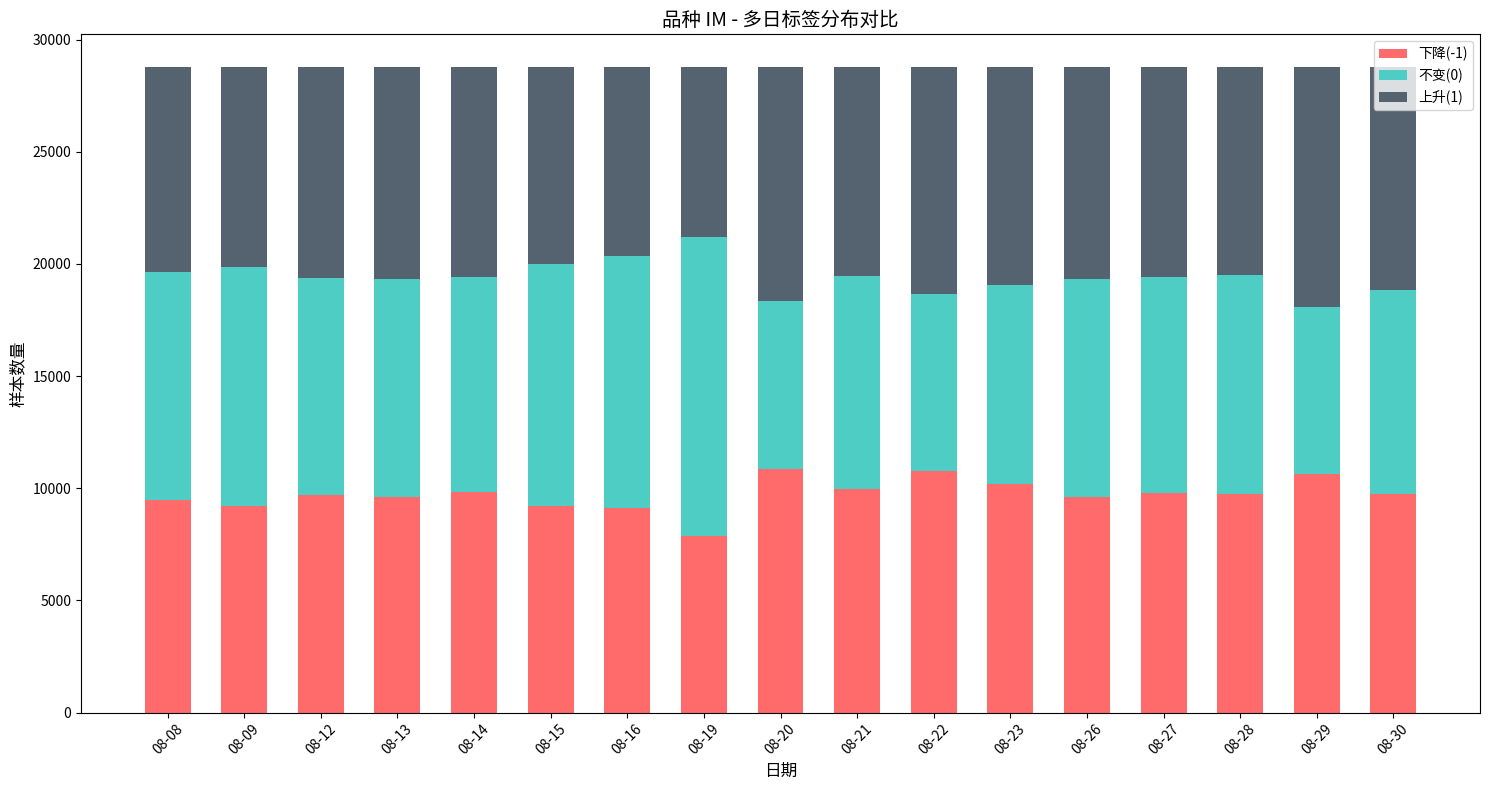

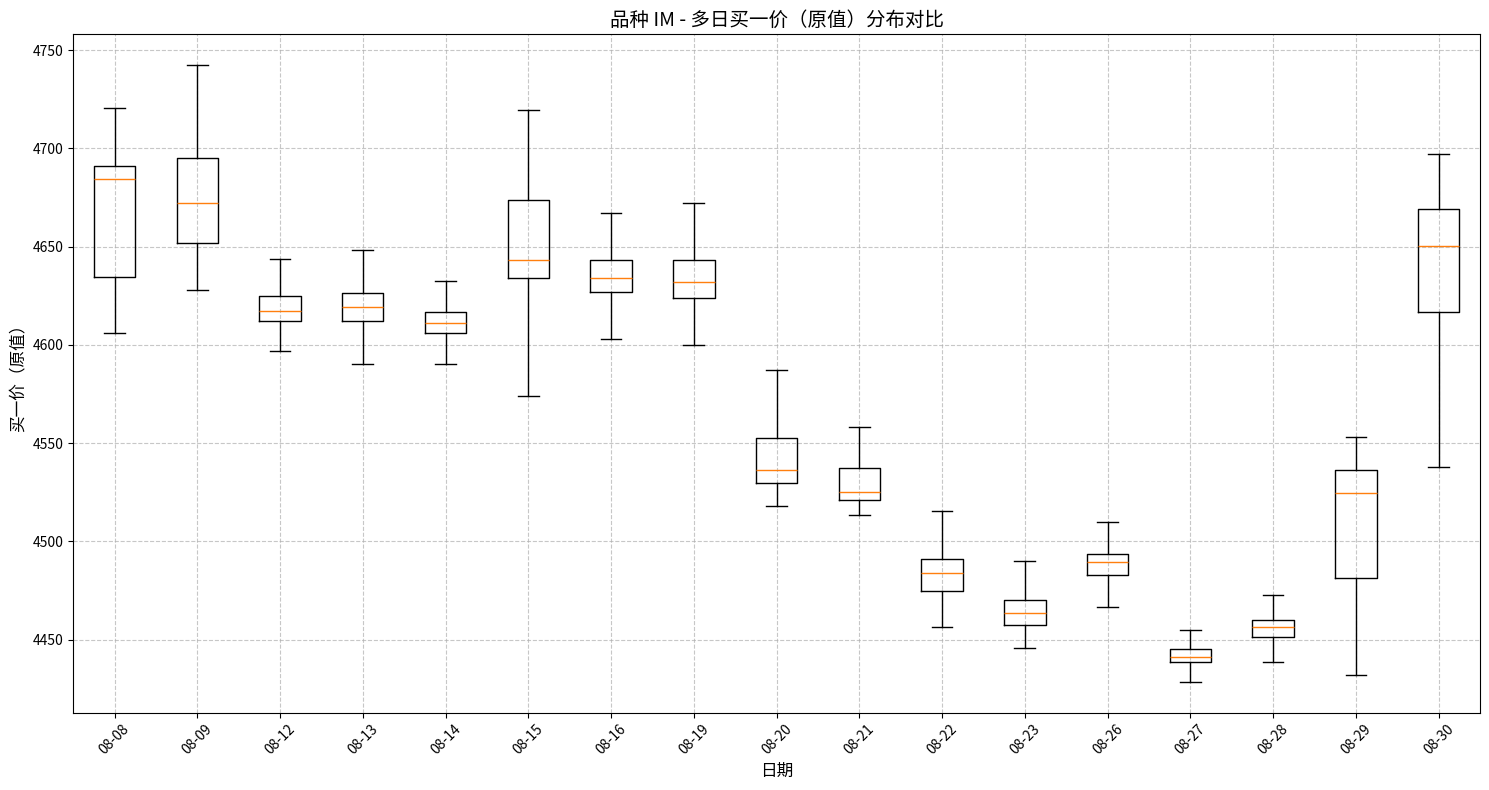

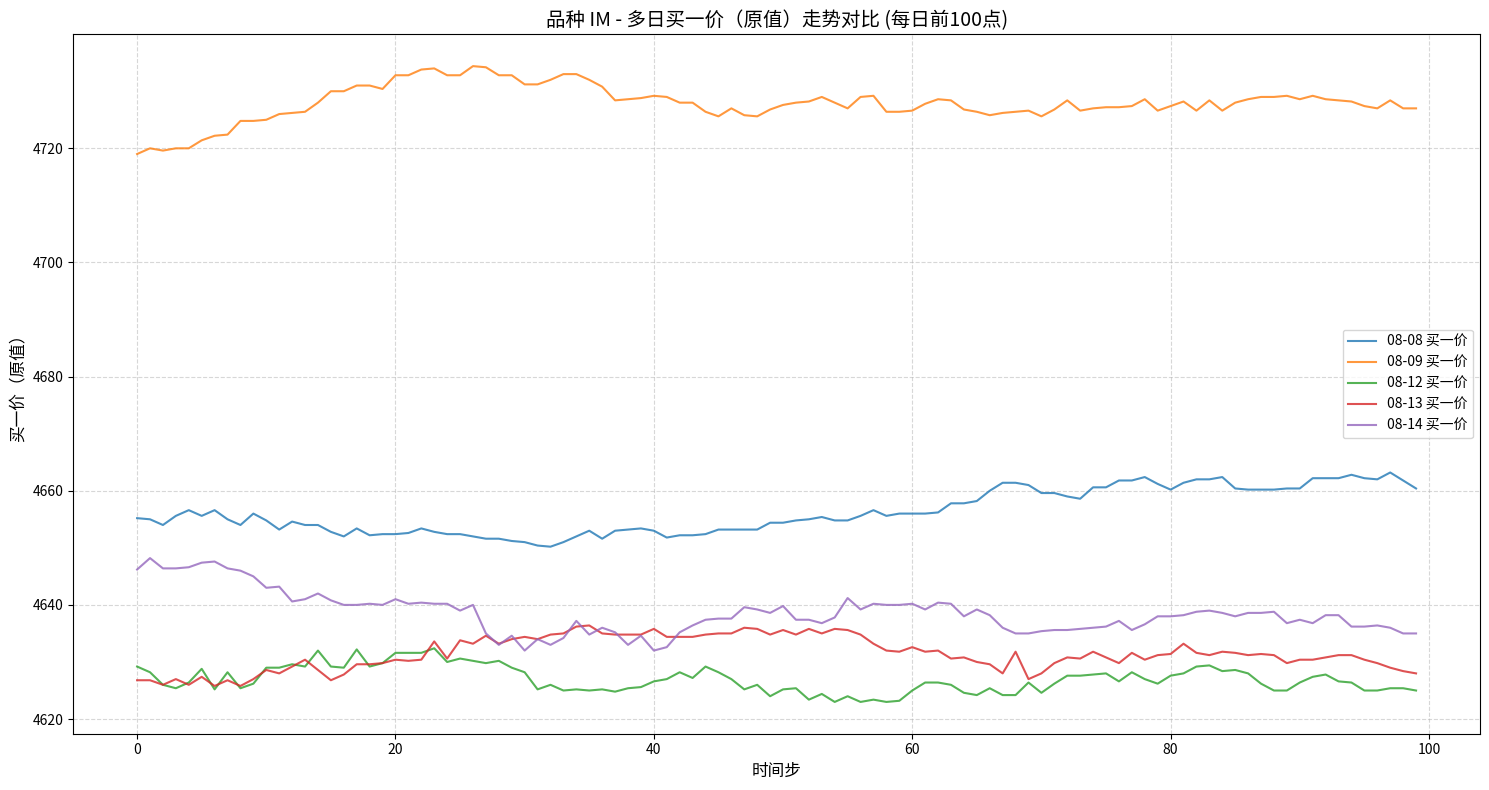

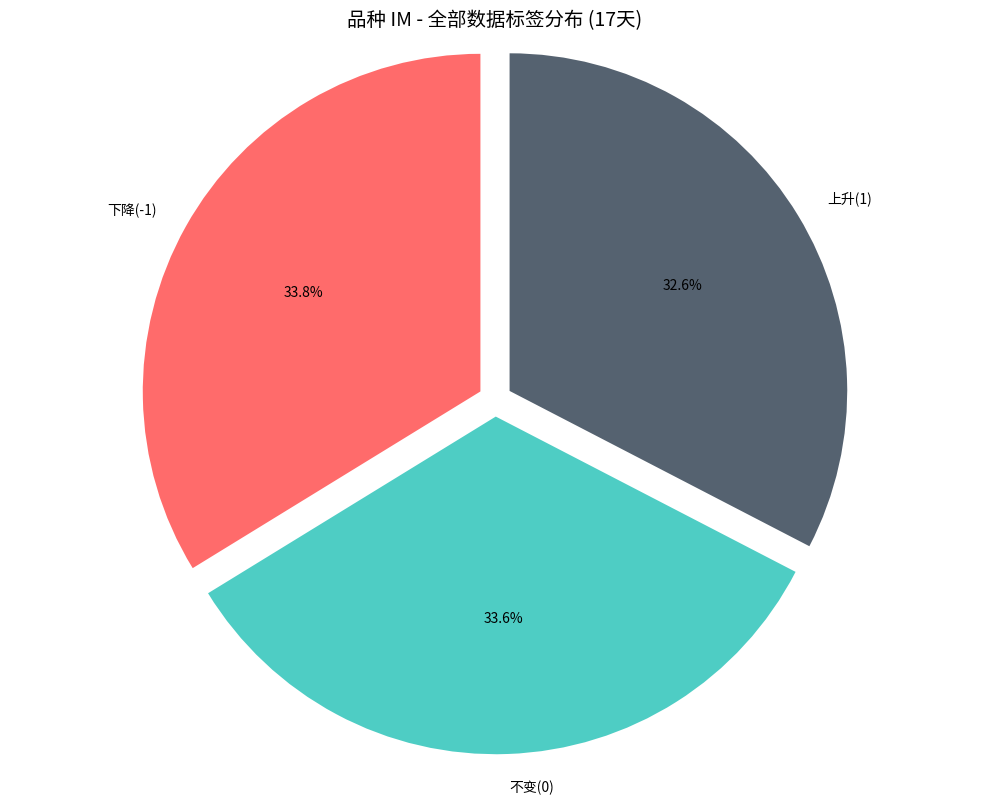

数据已保存到 ./data_cache/IM_daily_norm_data_dict.pkl
数据已保存到 ./data_cache/IM_daily_label_dict.pkl
数据已保存到 ./data_cache/IM_norm_mean_dict.pkl
数据已保存到 ./data_cache/IM_norm_stddev_dict.pkl

IM 数据处理完成并已保存到 ./data_cache 目录


In [ ]:
result_by_symbol = process_multi_day_data(
    START_DATE, END_DATE, symbol_types=SYMBOL_TYPES
)

if result_by_symbol:
    print("\n===== 处理后的数据示例 =====")

    for symbol_type, data_dict in result_by_symbol.items():
        print(f"\n品种: {symbol_type}")

        if not data_dict.get('daily_norm_data_dict'):
            print(f"品种 {symbol_type} 没有足够的数据来生成样本。可能是回看期(LOOKBACK_WINDOW)内的交易日不足。")
            continue

        # 可用日期
        dates = sorted(list(data_dict['daily_norm_data_dict'].keys()))
        print(f"\n可用日期列表: {dates}")

        # 选一天看形状/前几列（提醒：前 20 列是原始盘口）
        sample_date = dates[0]
        sample_day_arr = data_dict['daily_norm_data_dict'][sample_date]
        print(f"\n日期 {sample_date} 的处理后数据形状: {sample_day_arr.shape}")
        print("说明：列 0..4=BidPrice1..5（原值），5..9=AskPrice1..5（原值），10..14=BidVolume1..5（原值），15..19=AskVolume1..5（原值）；其余为标准化特征")
        print(f"前5行数据示例（前10列）:\n{sample_day_arr[:5, :10]}")

        # 标签分布（转 int 打印更干净）
        if sample_date in data_dict['daily_label_dict']:
            labels_day = np.asarray(data_dict['daily_label_dict'][sample_date]).reshape(-1)
            u, c = np.unique(labels_day.astype(int), return_counts=True)
            print(f"\n标签分布: {dict(zip(u.tolist(), c.tolist()))}")
            print(f"标签示例: {labels_day[:10]}")

        # —— 逐日统计（总特征长度 & 总标签长度）——
        T_total = sum(len(data_dict['daily_norm_data_dict'][d]) for d in dates)
        L_total = sum(len(np.asarray(data_dict['daily_label_dict'].get(d, [])).reshape(-1)) for d in dates)
        print(f"\n特征数据形状（合并后）: ({T_total}, {sample_day_arr.shape[1]})")
        print(f"标签总长度（逐日合计）: {L_total}  ≈  特征总长度 - 天数*K = {T_total - len(dates)*K}")
# 生成全局滑窗数据（跨日）
        X, y = generate_X_y(data_dict['daily_norm_data_dict'], data_dict['daily_label_dict'])

        if X is not None and y is not None:
            print(f"\n生成的训练数据形状（全局滑窗，可能跨日）: X: {X.shape}, y: {y.shape}")
            print("X示例(第一个样本的前5个时间步 × 前5个特征):")
            print(X[0, :5, :5, 0])
            print("y示例(前5个样本):")
            print(y[:5])


        # 可视化（已改为“买一价（原值）”表述）
        try:
            visualize_data(data_dict['daily_norm_data_dict'], data_dict['daily_label_dict'], symbol_type=symbol_type)
        except Exception as e:
            print(f"可视化数据时出错: {e}")

        # 保存处理后的数据
        save_processed_data(data_dict['daily_norm_data_dict'], f'{symbol_type}_daily_norm_data_dict.pkl')
        save_processed_data(data_dict['daily_label_dict'],     f'{symbol_type}_daily_label_dict.pkl')
        save_processed_data(data_dict['norm_mean_dict'],       f'{symbol_type}_norm_mean_dict.pkl')
        save_processed_data(data_dict['norm_stddev_dict'],     f'{symbol_type}_norm_stddev_dict.pkl')

        print(f"\n{symbol_type} 数据处理完成并已保存到 {DATA_CACHE_DIR} 目录")
else:
    print("数据处理失败，请检查日期范围或本地Parquet文件 'IM00_subset.parquet' 是否存在且包含有效数据。")


我们先尝试TransformerLOB ，是一个强大的时间序列分类模型，结合了卷积、位置编码和 Transformer 编码器，适用于复杂的时间序列数据分析任务。

In [ ]:
# cell5: (新版本，适配 TransformerLOB 模型)

# --- 模型参数 ---
D_MODEL = 128            # Transformer内部的工作维度 (必须能被ATTENTION_NUM_HEADS整除)
ATTENTION_NUM_HEADS = 16  # 多头注意力头数 (8个头，128/8=16)
NUM_ENCODER_LAYERS = 3   # Transformer编码器层数
DIM_FEEDFORWARD = 256    # 前馈网络维度
MODEL_DROPOUT = 0.2      # Transformer通常用稍小的Dropout

# --- 训练参数 ---
BATCH_SIZE = 256
NUM_EPOCHS = 100
PATIENCE = 15
LEARNING_RATE = 3e-4     # Transformer对学习率更敏感，通常从一个较小的值开始
TEST_SIZE = 0.2

In [ ]:
# cell6 (全新版本: TransformerLOB 模型)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math

# --- 1. 自定义数据集和早停类 (保持不变) ---
# 这部分代码和您原来的一样，这里为了完整性再次包含
class DeepLOBDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        if device is not None:
            self.features = self.features.to(device)
            self.labels = self.labels.to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_metric_min = -float('inf') # 监控F1分数，所以初始值是负无穷
        self.delta = delta
        self.path = path

    def __call__(self, val_f1_score, model):
        score = val_f1_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
        elif score < self.best_score + self.delta: # F1分数应该越大越好
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, val_f1_score, model):
        if self.verbose:
            print(f'Validation F1 score improved ({self.val_metric_min:.6f} --> {val_f1_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_metric_min = val_f1_score

# --- 2. TransformerLOB 模型定义 ---

# 辅助模块: 位置编码 (Positional Encoding)
# Transformer没有时序概念，需要我们手动给它加上位置信息
# class PositionalEncoding(nn.Module):
#    def __init__(self, d_model, max_len=5000):
#        super(PositionalEncoding, self).__init__()
#        pe = torch.zeros(max_len, d_model)
#        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#        pe[:, 0::2] = torch.sin(position * div_term)
#        pe[:, 1::2] = torch.cos(position * div_term)
#        pe = pe.unsqueeze(0).transpose(0, 1)
#        self.register_buffer('pe', pe)
#
#    def forward(self, x):
#        # x 的形状是 (timestep, batch, d_model)
#        x = x + self.pe[:x.size(0), :]
#        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # 创建一个可学习的embedding层
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        # x 的形状是 (timestep, batch, d_model)
        # 创建位置索引
        positions = torch.arange(0, x.size(0), device=x.device).unsqueeze(1) # -> (timestep, 1)
        # 查找位置编码并加到输入上
        return x + self.pos_embedding(positions)

class TransformerLOB(nn.Module):
    def __init__(self, feature_num, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        """
        一个基于纯Transformer的订单簿预测模型。

        参数:
        - feature_num: 输入特征的数量 (例如，您筛选后的40个)
        - d_model: Transformer内部的工作维度，必须能被nhead整除
        - nhead: 多头注意力的头数
        - num_encoder_layers: Transformer编码器层的数量
        - dim_feedforward: 编码器中前馈网络的维度
        - dropout: Dropout比率
        """
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model

        # 1. 输入层：将原始特征投影到Transformer的工作维度 (d_model)
        # 我们用一个1D卷积来实现，这很高效，可以看作一个作用于特征维度的线性层
        self.input_proj = nn.Conv1d(in_channels=feature_num, out_channels=d_model, kernel_size=1)

        # 2. 位置编码
        self.pos_encoder = PositionalEncoding(d_model)

        # 3. Transformer编码器
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # 关键参数，让输入可以是 (batch, seq_len, features)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)

        # 4. 输出分类器
        # 我们对所有时间步的输出取平均，然后进行分类
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 3)
        )

        self._init_weights()

        self.attentive_pool = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1)
        )

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        # x: (batch, timestep, features, 1)
        x = x.squeeze(-1)  # -> (batch, timestep, features)

        # --- 输入投影 ---
        # 卷积需要 (batch, channels, length) 的格式，我们这里的特征是channels
        x = x.permute(0, 2, 1)  # -> (batch, features, timestep)
        x = self.input_proj(x)   # -> (batch, d_model, timestep)
        x = x.permute(0, 2, 1)  # -> (batch, timestep, d_model)

        # --- 添加位置编码 ---
        # PositionalEncoding需要 (timestep, batch, d_model)
        x = x.permute(1, 0, 2)  # -> (timestep, batch, d_model)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # -> (batch, timestep, d_model)

        # --- 通过Transformer编码器 ---
        output = self.transformer_encoder(x)  # -> (batch, timestep, d_model)

        # --- 决策 ---
        # output 的形状是 (batch, timestep, d_model)
        # 1. 计算每个时间步的权重
        final_representation = output[:, -1, :]  # -> (batch, d_model)

        # --- 分类 ---
        logits = self.classifier(final_representation)
        return logits

# --- 3. 新的模型初始化函数 ---
def initiate_transformer_model(feature_num, **kwargs):
    """
    初始化 TransformerLOB 模型
    """
    print("正在初始化 TransformerLOB 模型...")
    model = TransformerLOB(
        feature_num=feature_num,
        d_model=kwargs.get('d_model', 128),
        nhead=kwargs.get('nhead', 8),
        num_encoder_layers=kwargs.get('num_encoder_layers', 3),
        dim_feedforward=kwargs.get('dim_feedforward', 256),
        dropout=kwargs.get('dropout', 0.1)
    )
    return model

这个选参部分并没有让模型更好，先注释掉，后期进行修正

In [ ]:
# # ==============================================================================
# #                 特征选择单元格 (Feature Selection Cell)
# #
# # 目的: 使用一个快速的 LightGBM 模型来分析所有原始特征的重要性，
# #       输出应保留的原始特征索引列表（按重要性排序取前 N 个）。
# #
# # 使用方法:
# #   1) 先运行前面的数据处理单元格，通常会得到 X 和 y_one_hot；
# #      若未定义，本单元格会尝试从 result_by_symbol 自动生成。
# #   2) 单独运行本单元格。
# #   3) 复制打印出来的 important_feature_indices 到后续单元使用。
# # ==============================================================================

# import lightgbm as lgb
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# print("--- 特征选择流程开始 ---")

# # ---------------- 第 1 步：准备数据（展平时序） ----------------
# print("步骤 1/4: 正在准备数据...")

# # 若 X / y_one_hot 未定义，尝试从 result_by_symbol 自动生成
# if 'X' not in globals() or 'y_one_hot' not in globals():
#     print("[提示] 未检测到 X / y_one_hot，尝试从 result_by_symbol 自动生成…")
#     if 'result_by_symbol' in globals() and 'generate_X_y' in globals():
#         # 任选一个品种；如需固定请手动改成 'IM' 等
#         symbol_type = next(iter(result_by_symbol.keys()))
#         daily_norm  = result_by_symbol[symbol_type]['daily_norm_data_dict']
#         daily_label = result_by_symbol[symbol_type]['daily_label_dict']
#         X, y_one_hot = generate_X_y(daily_norm, daily_label)
#         print(f"[OK] 生成 X={X.shape}, y_one_hot={y_one_hot.shape} (symbol={symbol_type})")
#     else:
#         raise RuntimeError("X / y_one_hot 未定义，且无法从 result_by_symbol 构造。请先运行数据处理单元格。")

# num_samples, num_timesteps, num_features, _ = X.shape
# flat_X   = X.reshape(num_samples, num_timesteps * num_features)
# y_labels = np.argmax(y_one_hot, axis=1)
# print(f"数据准备完毕。原始特征数: {num_features}, 展平特征数: {flat_X.shape[1]}")

# # ---------------- 第 2 步：按时间切分并训练 LGBM ----------------
# print("\n步骤 2/4: 正在训练 LightGBM 以评估特征重要性…")

# TEST_SIZE = globals().get('TEST_SIZE', 0.2)  # 若外部未定义，默认0.2
# train_size = int(len(flat_X) * (1 - TEST_SIZE))

# X_train_full_lgb, X_test_lgb = flat_X[:train_size], flat_X[train_size:]
# y_train_full_lgb, y_test_lgb = y_labels[:train_size], y_labels[train_size:]

# # 从训练末尾切 10% 做验证
# val_size = int(len(X_train_full_lgb) * 0.1)
# X_val_lgb, y_val_lgb = X_train_full_lgb[-val_size:], y_train_full_lgb[-val_size:]
# X_train_lgb, y_train_lgb = X_train_full_lgb[:-val_size], y_train_full_lgb[:-val_size]

# # —— 最小改动：在分割边界留“gap”，避免窗口重叠导致评估偏乐观 ——
# # gap = (窗口长度-1) + 未来步K；若 K 未定义则取 0
# gap = (num_timesteps - 1) + (globals().get('K', 0))
# if gap > 0:
#     # Train→Val 留缝
#     X_train_lgb, y_train_lgb = X_train_lgb[:-gap], y_train_lgb[:-gap]
#     # Val→Test 留缝（即使本 cell 不评测 test，这样更稳）
#     X_val_lgb,   y_val_lgb   = X_val_lgb[:-gap],   y_val_lgb[:-gap]

# print(f"[gap={gap}] train={len(X_train_lgb)}, val={len(X_val_lgb)}, test={len(X_test_lgb)}, total={len(flat_X)}")

# # 定义并训练 LGBM（多分类）
# lgbm_model = lgb.LGBMClassifier(
#     objective='multiclass',
#     metric='multi_logloss',
#     n_estimators=1000,
#     learning_rate=0.05,
#     random_state=42,
#     n_jobs=-1,
#     colsample_bytree=0.8,
#     subsample=0.8
# )
# lgbm_model.fit(
#     X_train_lgb, y_train_lgb,
#     eval_set=[(X_val_lgb, y_val_lgb)],
#     callbacks=[lgb.early_stopping(100, verbose=False)]
# )
# print("LightGBM 模型训练完成。")

# # ---------------- 第 3 步：汇总“原始特征”的总重要性 ----------------
# print("\n步骤 3/4: 正在计算每个原始特征的总重要性…")

# # 生成特征名（展平顺序：先 time 再 feature，匹配上面的 reshape）
# original_feature_names = [f'feature_{i}' for i in range(num_features)]
# feature_names = [f'{name}_t-{t}' for t in range(num_timesteps) for name in original_feature_names]

# feature_importance_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': lgbm_model.feature_importances_
# })
# # 解析出原始特征索引（如 'feature_58_t-0' → 58）
# feature_importance_df['original_feature_index'] = feature_importance_df['feature'].apply(
#     lambda x: int(x.split('_')[1])
# )

# # 按“原始特征索引”汇总（把同一原始特征在各时间步的贡献加总）
# original_feature_importance = (
#     feature_importance_df
#     .groupby('original_feature_index')['importance']
#     .sum()
#     .sort_values(ascending=False)
#     .to_frame()
# )

# print("原始特征重要性计算完毕。")

# # ---------------- 第 4 步：筛选前 N 个原始特征并可视化 ----------------
# print("\n步骤 4/4: 正在筛选并打印最终要保留的特征列表…")

# NUM_FEATURES_TO_KEEP = 40  # 可按需调整
# important_features_df = original_feature_importance.head(NUM_FEATURES_TO_KEEP)
# important_indices = sorted(important_features_df.index.tolist())

# num_kept = len(important_indices)
# num_dropped = num_features - num_kept

# print("\n--- 特征选择完成 ---")
# print(f"筛选策略: 保留最重要的 {NUM_FEATURES_TO_KEEP} 个原始特征")
# print(f"原始总特征数: {num_features}")
# print(f"筛选后保留特征数: {num_kept}")
# print(f"被剔除的冗余/弱特征数: {num_dropped}")

# print("\n=============== 最终结果 ================")
# print("important_feature_indices =", important_indices)
# print("=========================================\n")

# # 可视化
# plt.figure(figsize=(15, 7))
# plot_df = original_feature_importance.sort_index()  # 为了按索引递增显示
# plot_df['importance'].plot(kind='bar', alpha=0.8)
# plot_df.loc[important_indices, 'importance'].plot(kind='bar', alpha=0.8)
# plt.title('每个原始特征的总重要性得分（红色=选中）', fontsize=16)
# plt.xlabel('原始特征索引', fontsize=12)
# plt.ylabel('总重要性 (LightGBM)', fontsize=12)
# plt.xticks(rotation=90)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.legend(['未选中', '选中'])
# plt.tight_layout()
# plt.show()


0..4 → BidPrice1..5（原值）

5..9 → AskPrice1..5（原值）

10..14 → BidVolume1..5（原值）

15..19 → AskVolume1..5（原值）

20..27 → 邻档价差（Ask(i+1)-Ask(i)、Bid(i)-Bid(i+1) ×4对）

28..32 → 各档中间价 mid1..mid5

33..37 → 各档买卖差 (Ask_i - Bid_i)

38..47 → 累计量（按档递增：AskCum1,BidCum1,…,AskCum5,BidCum5）

48 → 量比 BidCum/(BidCum+AskCum)

49..51 → 动量窗口 5/10/20

52..54 → 波动率窗口 10/30/60

55 → OFI

56..58 → OFI 滚动和 10/30/60




==================== 处理品种: IM ====================
特征数据形状: (489515, 59)
标签数据形状: (489515, 1)
筛选前 X 的形状: (489506, 10, 59, 1)
筛选后(用于训练) X 的形状: (489506, 10, 39, 1)
IM 训练集: X (352430, 10, 39, 1), y (352430, 3)
IM 验证集: X (39146, 10, 39, 1), y (39146, 3)
IM 测试集(用于模型): X (97902, 10, 39, 1), y (97902, 3)
IM 测试集(含原盘口，供回测): X (97902, 10, 59, 1)
使用设备: cuda:0
类别计数: [118685 120095 113650]
类别权重: [2.969457  2.9345934 3.101012 ]
正在初始化 TransformerLOB 模型...
TransformerLOB(
  (input_proj): Conv1d(39, 128, kernel_size=(1,), stride=(1,))
  (pos_encoder): PositionalEncoding(
    (pos_embedding): Embedding(5000, 128)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (

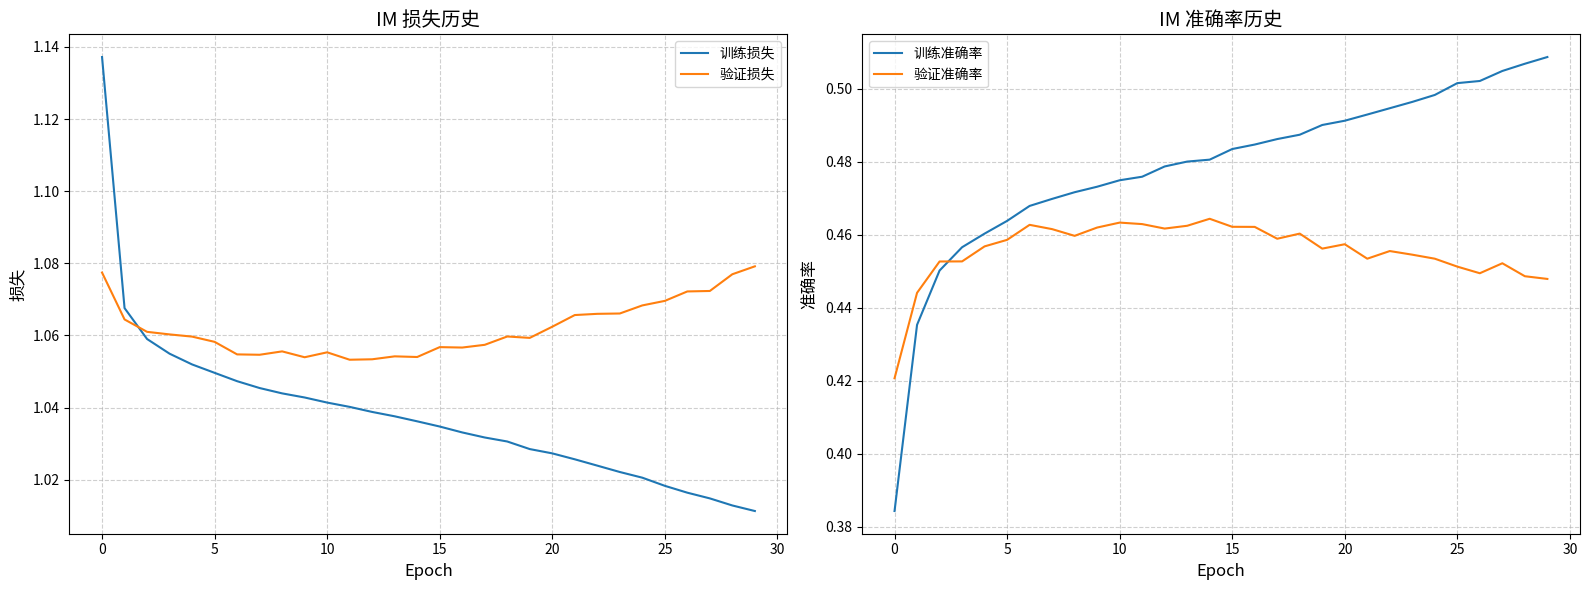

混淆矩阵图已保存至: ./data_cache/visualizations/IM_confusion_matrix.png


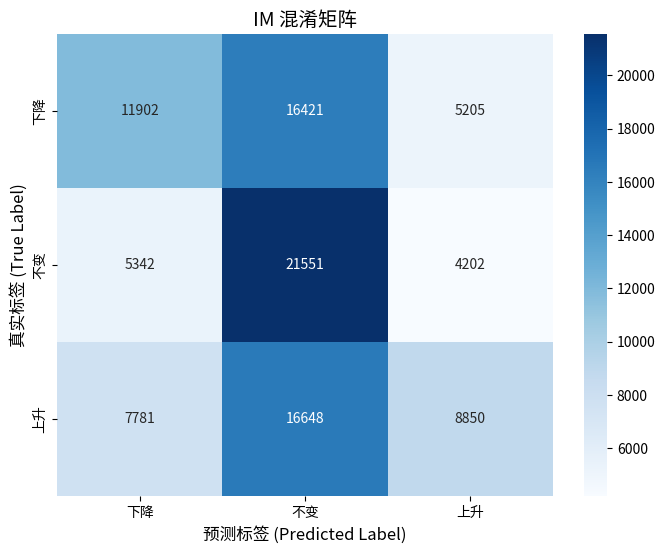


所有品种处理完成


In [ ]:
import math
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns

# --- 辅助函数 ---

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    """创建带有预热和余弦衰减的学习率调度器。"""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

def plot_confusion_matrix(y_true, y_pred, class_labels, symbol_type):
    """绘制并保存混淆矩阵图。"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{symbol_type} 混淆矩阵', fontsize=14)
    plt.ylabel('真实标签 (True Label)', fontsize=12)
    plt.xlabel('预测标签 (Predicted Label)', fontsize=12)

    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    save_path = os.path.join(vis_output_dir, f'{symbol_type}_confusion_matrix.png')
    plt.savefig(save_path)
    print(f"混淆矩阵图已保存至: {save_path}")
    plt.show()

def plot_training_history(history, symbol_type):
    """绘制并保存训练和验证的损失/准确率历史曲线。"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 绘制损失历史
    ax1.plot(history['train_loss'], label='训练损失')
    ax1.plot(history['val_loss'], label='验证损失')
    ax1.set_title(f'{symbol_type} 损失历史', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('损失', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # 绘制准确率历史
    ax2.plot(history['train_acc'], label='训练准确率')
    ax2.plot(history['val_acc'], label='验证准确率')
    ax2.set_title(f'{symbol_type} 准确率历史', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('准确率', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    save_path = os.path.join(vis_output_dir, f'{symbol_type}_training_history.png')
    plt.savefig(save_path)
    print(f"训练历史图已保存至: {save_path}")
    plt.show()
RAW_N = 20  # >>> 修改点：前 20 列为原始盘口(L1~L5价量)，训练时剔除

for symbol_type in SYMBOL_TYPES:
    print(f"\n{'='*20} 处理品种: {symbol_type} {'='*20}")

    try:
        daily_norm_data_dict = load_processed_data(f'{symbol_type}_daily_norm_data_dict.pkl')
        daily_label_dict     = load_processed_data(f'{symbol_type}_daily_label_dict.pkl')
        if daily_norm_data_dict is None or daily_label_dict is None:
            print(f"未找到 {symbol_type} 的缓存数据，跳过训练。")
            continue
    except FileNotFoundError:
        print(f"缓存文件未找到，跳过 {symbol_type} 的训练。")
        continue

    # 生成样本（X 内部已包含原始盘口 20 列在最前面）
    X_full, y_one_hot = generate_X_y(daily_norm_data_dict, daily_label_dict)  # >>> 修改点：保留一份完整的 X
    if X_full is None or y_one_hot is None:
        print(f"为 {symbol_type} 生成数据失败，跳过训练。")
        continue

    print(f"筛选前 X 的形状: {X_full.shape}")
    F = X_full.shape[2]
    assert F >= RAW_N, f"特征数 {F} < RAW_N={RAW_N}。请先确认 prepare_orderbook_data 把原始盘口放在最前面。"

    # 训练输入：剔除前 20 列原始盘口，只用后面的标准化特征
    important_feature_indices = list(range(RAW_N, F))  # >>> 修改点：自动排除 0..19
    X_in = X_full[:, :, important_feature_indices, :]
    print(f"筛选后(用于训练) X 的形状: {X_in.shape}")

    # 1) 时间切分（保持顺序）
    train_size = int(len(X_in) * (1 - TEST_SIZE))
    X_train_full, X_test_in = X_in[:train_size], X_in[train_size:]
    y_train_full, y_test    = y_one_hot[:train_size], y_one_hot[train_size:]

    # 同步保留一份“含原始盘口”的 X，供回测开仓价直接使用（不参与训练）
    X_test_full = X_full[train_size:]  # >>> 修改点：这份里含 20 列原始盘口

    # 2) 从训练集末尾划 10% 做验证
    val_size = int(len(X_train_full) * 0.1)
    X_val_in, y_val = X_train_full[-val_size:], y_train_full[-val_size:]
    X_train_in, y_train = X_train_full[:-val_size], y_train_full[:-val_size]

    # 3) 留 gap 防泄露
    gap = (TIMESTAMP_PER_SAMPLE - 1) + K
    if len(X_train_in) > gap:
        X_train_in, y_train = X_train_in[:-gap], y_train[:-gap]   # Train→Val 留缝
    if len(X_val_in) > gap:
        X_val_in, y_val     = X_val_in[:-gap],   y_val[:-gap]     # Val→Test 留缝

    print(f"{symbol_type} 训练集: X {X_train_in.shape}, y {y_train.shape}")
    print(f"{symbol_type} 验证集: X {X_val_in.shape}, y {y_val.shape}")
    print(f"{symbol_type} 测试集(用于模型): X {X_test_in.shape}, y {y_test.shape}")
    print(f"{symbol_type} 测试集(含原盘口，供回测): X {X_test_full.shape}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 类别权重（基于训练集 one-hot 的 argmax）
    y_train_indices = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train_indices, minlength=3)
    if 0 in class_counts:
        print(f"警告: 训练集中存在样本数量为0的类别，无法计算权重。跳过 {symbol_type}。")
        continue
    total_samples = class_counts.sum()
    class_weights = torch.tensor([total_samples / count for count in class_counts],
                                 dtype=torch.float, device=device)
    print(f"类别计数: {class_counts}")
    print(f"类别权重: {class_weights.detach().cpu().numpy()}")

    # DataLoader（保持时间顺序）
    train_dataset = DeepLOBDataset(X_train_in, y_train, device)
    val_dataset   = DeepLOBDataset(X_val_in,   y_val,   device)
    test_dataset  = DeepLOBDataset(X_test_in,  y_test,  device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

    # 模型 & 优化
    feature_num = X_train_in.shape[2]  # >>> 修改点：用剔除后的特征数
    model_params = {
        'd_model': D_MODEL,
        'nhead': ATTENTION_NUM_HEADS,
        'num_encoder_layers': NUM_ENCODER_LAYERS,
        'dim_feedforward': DIM_FEEDFORWARD,
        'dropout': MODEL_DROPOUT
    }
    model = initiate_transformer_model(feature_num, **model_params).to(device)
    print(model)

    # >>> 修改点：CrossEntropyLoss 需传“类别索引”，不是 one-hot
    loss_fn  = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
    num_training_steps = len(train_loader) * NUM_EPOCHS
    num_warmup_steps   = len(train_loader) * 2   # 建议别用 15 个 epoch 预热，先用 2 个
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    model_save_path = f'./{symbol_type}_transformer_model.pth'
    early_stopping  = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)

    # 训练循环
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        # ---- 训练 ----
        model.train()
        train_loss, train_corrects = 0.0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels_idx = torch.argmax(labels, dim=1)          # >>> 修改点
            loss = loss_fn(outputs, labels_idx)               # >>> 修改点
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_corrects += torch.sum(preds == labels_idx).item()

        train_loss /= len(train_loader.dataset)
        train_acc   = train_corrects / len(train_loader.dataset)

        # ---- 验证 ----
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels_idx = torch.argmax(labels, dim=1)      # >>> 修改点
                loss = loss_fn(outputs, labels_idx)           # >>> 修改点
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_corrects += torch.sum(preds == labels_idx).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels_idx.cpu().numpy())

        val_loss    /= len(val_loader.dataset)
        val_acc      = val_corrects / len(val_loader.dataset)
        val_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{NUM_EPOCHS} - "
              f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - "
              f"val_f1_macro: {val_f1_macro:.4f} - lr: {optimizer.param_groups[0]['lr']:.6f}")

        if early_stopping(val_f1_macro, model):
            print(f"\n早停触发 (基于 macro F1-score)，在 epoch {epoch} 停止训练")
            break

    # 测试评估
    print("\n--- 模型最终评估 ---")
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    all_preds_final, all_labels_final = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds_final.extend(preds.cpu().numpy())
            all_labels_final.extend(torch.argmax(labels, dim=1).cpu().numpy())

    report = classification_report(
        all_labels_final, all_preds_final,
        target_names=CLASS_LABELS, zero_division=0
    )
    print(report)

    print(f"\n{symbol_type} Transformer 模型已保存为 '{model_save_path}'")

    # 可视化
    print("\n--- 结果可视化 ---")
    plot_training_history(history, symbol_type)
    plot_confusion_matrix(all_labels_final, all_preds_final, CLASS_LABELS, symbol_type)

print("\n所有品种处理完成")


现在我们试试deeplob

ImprovedDeepLOB 是对原始 DeepLOB 模型的改进版本，结合了 残差卷积块 (ResidualConvBlock)、双向 LSTM 和 多头注意力机制 (Multihead Attention)，并通过残差连接和归一化层增强了模型的稳定性和性能。

In [ ]:
# --- 模型参数 ---
# CNN部分
CNN_FILTERS_1 = 16      # 第一个卷积层的滤波器数量
CNN_FILTERS_2 = 32      # 第二个卷积层的滤波器数量

# LSTM部分
LSTM_HIDDEN_UNITS = 32  # LSTM隐藏单元数量
LSTM_NUM_LAYERS = 2     # LSTM层数

# Attention部分
ATTENTION_NUM_HEADS = 4 # 多头注意力头数

# 通用参数
MODEL_DROPOUT = 0.5     # 模型中统一的Dropout率
LEAKY_RELU_ALPHA = 0.01 # LeakyReLU的alpha参数 (虽然新模型用ReLU，但保留以备用)

# --- 训练参数 ---
BATCH_SIZE = 512      # 新模型可能对显存更友好，可以适当调大Batch Size
NUM_EPOCHS = 100        # 由于模型更简单，可能不需要那么多Epochs，可以先设为100
PATIENCE = 15           # 早停的耐心值
LEARNING_RATE = 5e-4    # 这种模型通常对稍大的学习率更不敏感，可以从1e-3开始尝试
TEST_SIZE = 0.2         # 测试集比例

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F

class ResidualConvBlock(nn.Module):
    """
    A residual block for 1D convolutions.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut connection to match dimensions if in_channels != out_channels
        if in_channels == out_channels:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False), # 1x1 conv for projection
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += residual  # Add the residual
        return F.relu(out) # Apply final activation

# # --- 1. 自定义数据集和早停类 (保持不变) ---
# class DeepLOBDataset(Dataset):
#     def __init__(self, features, labels, device=None):
#         self.features = torch.FloatTensor(features)
#         self.labels = torch.FloatTensor(labels)
#         if device is not None:
#             self.features = self.features.to(device)
#             self.labels = self.labels.to(device)
#     def __len__(self):
#         return len(self.features)
#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

# class EarlyStopping:
#     def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_metric_min = float('inf')
#         self.delta = delta
#         self.path = path

#     # 修改为监控验证集F1分数
#     def __call__(self, val_f1_score, model):
#         score = val_f1_score
#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_f1_score, model)
#         elif score <= self.best_score + self.delta:
#             self.counter += 1
#             if self.verbose:
#                 print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_f1_score, model)
#             self.counter = 0
#         return self.early_stop

#     def save_checkpoint(self, val_f1_score, model):
#         if self.verbose:
#             print(f'Validation F1 score improved ({self.val_metric_min:.6f} --> {val_f1_score:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), self.path)
#         self.val_metric_min = val_f1_score


# --- 2. 新模型: ImprovedDeepLOB ---
class ImprovedDeepLOB(nn.Module):
    def __init__(self, feature_num,
                 cnn_filters_1=32, cnn_filters_2=64,
                 lstm_hidden_dim=64, lstm_num_layers=2,
                 attention_num_heads=4,
                 dropout=0.3):
        super().__init__()

        # --- MODIFIED: Use ResidualConvBlock instead of nn.Sequential ---
        self.cnn_block1 = ResidualConvBlock(1, cnn_filters_1)
        self.cnn_block2 = ResidualConvBlock(cnn_filters_1, cnn_filters_2)

        # --- NEW: Projection for LSTM residual connection ---
        # This layer will match the dimensions of LSTM input to LSTM output
        self.lstm_input_proj = nn.Linear(feature_num * cnn_filters_2, lstm_hidden_dim * 2)

        # --- MODIFIED: LSTM layer remains the same ---
        self.lstm = nn.LSTM(
            input_size=feature_num * cnn_filters_2,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=dropout if lstm_num_layers > 1 else 0,
            bidirectional=True
        )

        # --- NEW: Layer Normalization for post-LSTM and post-Attention ---
        self.norm_lstm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.norm_attn = nn.LayerNorm(lstm_hidden_dim * 2)

        # --- MODIFIED: Attention layer remains the same ---
        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_hidden_dim * 2,
            num_heads=attention_num_heads,
            dropout=dropout,
            batch_first=True
        )

        # --- MODIFIED: Classifier remains the same ---
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * 2, lstm_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim, 3)
        )

        self._init_weights()

    def _init_weights(self):
        # Weight initialization is even more important with deeper/residual nets
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x: (batch, timestep, features, 1)
        batch_size, timestep, features, _ = x.shape
        x = x.squeeze(-1) # -> (batch, timestep, features)

        # --- CNN Feature Extraction ---
        x_reshaped = x.reshape(batch_size * timestep, 1, features) # -> (B*T, 1, F)

        # --- MODIFIED: Pass through residual CNN blocks ---
        cnn_out = self.cnn_block1(x_reshaped)
        cnn_out = self.cnn_block2(cnn_out)

        lstm_input_features = cnn_out.reshape(batch_size, timestep, -1) # -> (B, T, cnn_filters_2 * F)

        # --- LSTM with Residual Connection and LayerNorm ---
        lstm_out, _ = self.lstm(lstm_input_features)  # -> (B, T, hidden*2)

        # --- NEW: Add residual connection around LSTM ---
        residual_lstm = self.lstm_input_proj(lstm_input_features) # Project input to match output dim
        lstm_out = self.norm_lstm(lstm_out + residual_lstm) # Add & Norm

        # --- Attention with Residual Connection and LayerNorm (Standard Transformer Block) ---
        # Query, Key, and Value are all the output from the LSTM layer
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # --- NEW: Add residual connection around Attention ---
        attn_out = self.norm_attn(attn_out + lstm_out) # Add & Norm

        # --- Decision ---
        # Take the last time step's output for classification
        final_representation = attn_out[:, -1, :]  # -> (B, hidden*2)

        # --- Classifier ---
        logits = self.classifier(final_representation)
        return logits

def initiate_DeepLOB_model(feature_num, **kwargs):
    """
    初始化 ImprovedDeepLOB 模型
    """
    print("正在初始化 ImprovedDeepLOB 模型...")
    model = ImprovedDeepLOB(
        feature_num=feature_num,
        cnn_filters_1=kwargs.get('cnn_filters_1', 32),
        cnn_filters_2=kwargs.get('cnn_filters_2', 64),
        lstm_hidden_dim=kwargs.get('lstm_hidden_dim', 64),
        lstm_num_layers=kwargs.get('lstm_num_layers', 2),
        attention_num_heads=kwargs.get('attention_num_heads', 4),
        dropout=kwargs.get('dropout', 0.3)
    )
    return model


==================== 处理品种: IM ====================
特征数据形状: (489515, 59)
标签数据形状: (489515, 1)
筛选前 X 的形状: (489506, 10, 59, 1)
筛选后(用于训练) X 的形状: (489506, 10, 39, 1)
IM 训练集: X (352430, 10, 39, 1), y (352430, 3)
IM 验证集: X (39146, 10, 39, 1), y (39146, 3)
IM 测试集(用于模型): X (97902, 10, 39, 1), y (97902, 3)
IM 测试集(含原盘口，供回测): X (97902, 10, 59, 1)
使用设备: cuda:0
类别计数: [118685 120095 113650]
类别权重: [2.969457  2.9345934 3.101012 ]
正在初始化 TransformerLOB 模型...
TransformerLOB(
  (input_proj): Conv1d(39, 128, kernel_size=(1,), stride=(1,))
  (pos_encoder): PositionalEncoding(
    (pos_embedding): Embedding(5000, 128)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (

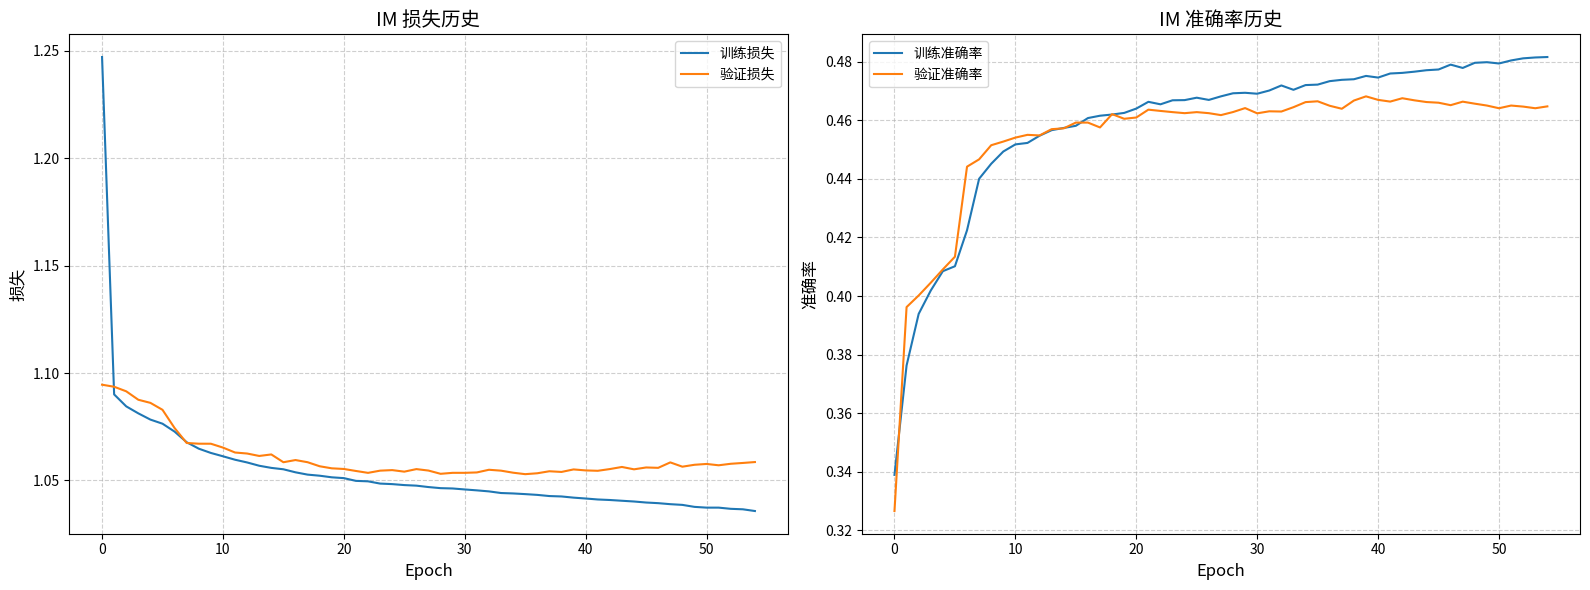

混淆矩阵图已保存至: ./data_cache/visualizations/IM_confusion_matrix.png


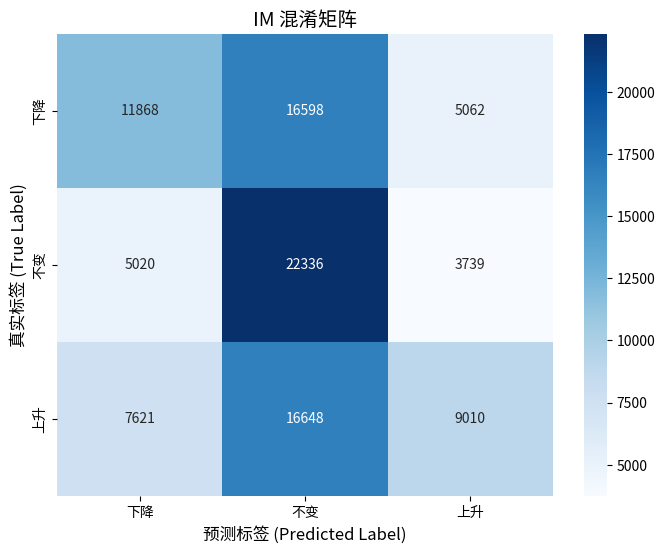


所有品种处理完成


In [ ]:
import math
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns


# def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
#     """创建带有预热和余弦衰减的学习率调度器。"""
#     def lr_lambda(current_step):
#         if current_step < num_warmup_steps:
#             return float(current_step) / float(max(1, num_warmup_steps))
#         progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
#         return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
#     return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

# def plot_confusion_matrix(y_true, y_pred, class_labels, symbol_type):
#     """绘制并保存混淆矩阵图。"""
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
#     plt.title(f'{symbol_type} 混淆矩阵', fontsize=14)
#     plt.ylabel('真实标签 (True Label)', fontsize=12)
#     plt.xlabel('预测标签 (Predicted Label)', fontsize=12)

#     vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
#     os.makedirs(vis_output_dir, exist_ok=True)

#     save_path = os.path.join(vis_output_dir, f'{symbol_type}_confusion_matrix.png')
#     plt.savefig(save_path)
#     print(f"混淆矩阵图已保存至: {save_path}")
#     plt.show()

# def plot_training_history(history, symbol_type):
#     """绘制并保存训练和验证的损失/准确率历史曲线。"""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # 绘制损失历史
#     ax1.plot(history['train_loss'], label='训练损失')
#     ax1.plot(history['val_loss'], label='验证损失')
#     ax1.set_title(f'{symbol_type} 损失历史', fontsize=14)
#     ax1.set_xlabel('Epoch', fontsize=12)
#     ax1.set_ylabel('损失', fontsize=12)
#     ax1.legend()
#     ax1.grid(True, linestyle='--', alpha=0.6)

#     # 绘制准确率历史
#     ax2.plot(history['train_acc'], label='训练准确率')
#     ax2.plot(history['val_acc'], label='验证准确率')
#     ax2.set_title(f'{symbol_type} 准确率历史', fontsize=14)
#     ax2.set_xlabel('Epoch', fontsize=12)
#     ax2.set_ylabel('准确率', fontsize=12)
#     ax2.legend()
#     ax2.grid(True, linestyle='--', alpha=0.6)

#     plt.tight_layout()

#     vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
#     os.makedirs(vis_output_dir, exist_ok=True)

#     save_path = os.path.join(vis_output_dir, f'{symbol_type}_training_history.png')
#     plt.savefig(save_path)
#     print(f"训练历史图已保存至: {save_path}")
#     plt.show()

RAW_N = 20  # >>> 修改点：前 20 列为原始盘口(L1~L5价量)，训练时剔除

for symbol_type in SYMBOL_TYPES:
    print(f"\n{'='*20} 处理品种: {symbol_type} {'='*20}")

    try:
        daily_norm_data_dict = load_processed_data(f'{symbol_type}_daily_norm_data_dict.pkl')
        daily_label_dict     = load_processed_data(f'{symbol_type}_daily_label_dict.pkl')
        if daily_norm_data_dict is None or daily_label_dict is None:
            print(f"未找到 {symbol_type} 的缓存数据，跳过训练。")
            continue
    except FileNotFoundError:
        print(f"缓存文件未找到，跳过 {symbol_type} 的训练。")
        continue

    # 生成样本（X 内部已包含原始盘口 20 列在最前面）
    X_full, y_one_hot = generate_X_y(daily_norm_data_dict, daily_label_dict)  # >>> 修改点：保留一份完整的 X
    if X_full is None or y_one_hot is None:
        print(f"为 {symbol_type} 生成数据失败，跳过训练。")
        continue

    print(f"筛选前 X 的形状: {X_full.shape}")
    F = X_full.shape[2]
    assert F >= RAW_N, f"特征数 {F} < RAW_N={RAW_N}。请先确认 prepare_orderbook_data 把原始盘口放在最前面。"

    # 训练输入：剔除前 20 列原始盘口，只用后面的标准化特征
    important_feature_indices = list(range(RAW_N, F))  # >>> 修改点：自动排除 0..19
    X_in = X_full[:, :, important_feature_indices, :]
    print(f"筛选后(用于训练) X 的形状: {X_in.shape}")

    # 1) 时间切分（保持顺序）
    train_size = int(len(X_in) * (1 - TEST_SIZE))
    X_train_full, X_test_in = X_in[:train_size], X_in[train_size:]
    y_train_full, y_test    = y_one_hot[:train_size], y_one_hot[train_size:]

    # 同步保留一份“含原始盘口”的 X，供回测开仓价直接使用（不参与训练）
    X_test_full = X_full[train_size:]  # >>> 修改点：这份里含 20 列原始盘口

    # 2) 从训练集末尾划 10% 做验证
    val_size = int(len(X_train_full) * 0.1)
    X_val_in, y_val = X_train_full[-val_size:], y_train_full[-val_size:]
    X_train_in, y_train = X_train_full[:-val_size], y_train_full[:-val_size]

    # 3) 留 gap 防泄露
    gap = (TIMESTAMP_PER_SAMPLE - 1) + K
    if len(X_train_in) > gap:
        X_train_in, y_train = X_train_in[:-gap], y_train[:-gap]   # Train→Val 留缝
    if len(X_val_in) > gap:
        X_val_in, y_val     = X_val_in[:-gap],   y_val[:-gap]     # Val→Test 留缝

    print(f"{symbol_type} 训练集: X {X_train_in.shape}, y {y_train.shape}")
    print(f"{symbol_type} 验证集: X {X_val_in.shape}, y {y_val.shape}")
    print(f"{symbol_type} 测试集(用于模型): X {X_test_in.shape}, y {y_test.shape}")
    print(f"{symbol_type} 测试集(含原盘口，供回测): X {X_test_full.shape}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 类别权重（基于训练集 one-hot 的 argmax）
    y_train_indices = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train_indices, minlength=3)
    if 0 in class_counts:
        print(f"警告: 训练集中存在样本数量为0的类别，无法计算权重。跳过 {symbol_type}。")
        continue
    total_samples = class_counts.sum()
    class_weights = torch.tensor([total_samples / count for count in class_counts],
                                 dtype=torch.float, device=device)
    print(f"类别计数: {class_counts}")
    print(f"类别权重: {class_weights.detach().cpu().numpy()}")

    # DataLoader（保持时间顺序）
    train_dataset = DeepLOBDataset(X_train_in, y_train, device)
    val_dataset   = DeepLOBDataset(X_val_in,   y_val,   device)
    test_dataset  = DeepLOBDataset(X_test_in,  y_test,  device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

    # 模型 & 优化
    feature_num = X_train_in.shape[2]  # >>> 修改点：用剔除后的特征数
    model_params = {
        'd_model': D_MODEL,
        'nhead': ATTENTION_NUM_HEADS,
        'num_encoder_layers': NUM_ENCODER_LAYERS,
        'dim_feedforward': DIM_FEEDFORWARD,
        'dropout': MODEL_DROPOUT
    }
    model = initiate_transformer_model(feature_num, **model_params).to(device)
    print(model)

    # >>> 修改点：CrossEntropyLoss 需传“类别索引”，不是 one-hot
    loss_fn  = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
    num_training_steps = len(train_loader) * NUM_EPOCHS
    num_warmup_steps   = len(train_loader) * 2   # 建议别用 15 个 epoch 预热，先用 2 个
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    model_save_path = f'./{symbol_type}_transformer_model.pth'
    early_stopping  = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)

    # 训练循环
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        # ---- 训练 ----
        model.train()
        train_loss, train_corrects = 0.0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels_idx = torch.argmax(labels, dim=1)          # >>> 修改点
            loss = loss_fn(outputs, labels_idx)               # >>> 修改点
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_corrects += torch.sum(preds == labels_idx).item()

        train_loss /= len(train_loader.dataset)
        train_acc   = train_corrects / len(train_loader.dataset)

        # ---- 验证 ----
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels_idx = torch.argmax(labels, dim=1)      # >>> 修改点
                loss = loss_fn(outputs, labels_idx)           # >>> 修改点
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_corrects += torch.sum(preds == labels_idx).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels_idx.cpu().numpy())

        val_loss    /= len(val_loader.dataset)
        val_acc      = val_corrects / len(val_loader.dataset)
        val_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{NUM_EPOCHS} - "
              f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - "
              f"val_f1_macro: {val_f1_macro:.4f} - lr: {optimizer.param_groups[0]['lr']:.6f}")

        if early_stopping(val_f1_macro, model):
            print(f"\n早停触发 (基于 macro F1-score)，在 epoch {epoch} 停止训练")
            break

    # 测试评估
    print("\n--- 模型最终评估 ---")
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    all_preds_final, all_labels_final = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds_final.extend(preds.cpu().numpy())
            all_labels_final.extend(torch.argmax(labels, dim=1).cpu().numpy())

    report = classification_report(
        all_labels_final, all_preds_final,
        target_names=CLASS_LABELS, zero_division=0
    )
    print(report)

    print(f"\n{symbol_type} Transformer 模型已保存为 '{model_save_path}'")

    # 可视化
    print("\n--- 结果可视化 ---")
    plot_training_history(history, symbol_type)
    plot_confusion_matrix(all_labels_final, all_preds_final, CLASS_LABELS, symbol_type)

print("\n所有品种处理完成")


In [ ]:
# --- 模型参数 ---
D_MODEL = 256            # Transformer内部的工作维度 (必须能被ATTENTION_NUM_HEADS整除)
ATTENTION_NUM_HEADS = 16  # 多头注意力头数
NUM_ENCODER_LAYERS = 3   # Transformer编码器层数
DIM_FEEDFORWARD = 256    # 前馈网络维度
MODEL_DROPOUT = 0.4      # Transformer通常用稍小的Dropout

# --- 预训练参数 (新增) ---
DO_PRETRAIN = True         # 是否执行预训练阶段
PRETRAIN_EPOCHS = 30       # 预训练的轮数 (可根据需要调整, 20-50)
MASK_PROB = 0.2           # 元素掩码的概率
TIME_STEP_MASK_PROB = 0.2  # 时间步掩码的概率 (每个样本中有20%的时间步被完全掩盖)
PRETRAIN_BATCH_SIZE = 4096  # 预训练使用更大的批量
PRETRAIN_LR = 1e-4         # 预训练学习率

# --- 微调训练参数 ---
FINETUNE_EPOCHS = 100      # 微调的轮数 (原 NUM_EPOCHS)
BATCH_SIZE = 2048
PATIENCE = 25
LEARNING_RATE = 3e-4     # 微调学习率 (原 LEARNING_RATE)
TEST_SIZE = 0.2

import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        return x + self.pos_embedding(positions)

class TransformerLOB(nn.Module):
    def __init__(self, feature_num, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model
        self.feature_num = feature_num  # 决定 reconstruction_head 的输出维度

        # 1) 输入投影: (B,T,F)->(B,T,d_model)
        self.input_proj = nn.Conv1d(in_channels=feature_num, out_channels=d_model, kernel_size=1)

        # 2) 位置编码
        self.pos_encoder = PositionalEncoding(d_model)

        # 3) Transformer 编码器
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)

        # 4) 注意力池化（对时间维做加权求和）
        self.attentive_pool = nn.Sequential(
            nn.Linear(d_model, 128), nn.Tanh(), nn.Linear(128, 1)
        )

        # 5) 分类头
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_model // 2, 3)
        )

        # 6) 重建头（预训练用）
        self.reconstruction_head = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, self.feature_num)
        )

        # 7) 回归头（波动率）
        self.regression_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_model // 4, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x: torch.Tensor):
        # x: (B, T, F, 1)
        x = x.squeeze(-1)              # (B,T,F)
        x = x.permute(0, 2, 1)         # (B,F,T)
        x = self.input_proj(x)         # (B,d_model,T)
        x = x.permute(0, 2, 1)         # (B,T,d_model)
        x = self.pos_encoder(x)        # (B,T,d_model)

        h = self.transformer_encoder(x)            # (B,T,d_model)
        att = F.softmax(self.attentive_pool(h), 1) # (B,T,1)
        z = (h * att).sum(1)                       # (B,d_model)

        logits = self.classifier(z)                # (B,3)
        recon  = self.reconstruction_head(h)       # (B,T,F)
        vol    = self.regression_head(z).squeeze(-1)  # (B,)
        return logits, recon, vol

def initiate_transformer_model(feature_num, **kwargs):
    return TransformerLOB(
        feature_num=feature_num,
        d_model=kwargs.get('d_model', 128),
        nhead=kwargs.get('nhead', 8),
        num_encoder_layers=kwargs.get('num_encoder_layers', 3),
        dim_feedforward=kwargs.get('dim_feedforward', 256),
        dropout=kwargs.get('dropout', 0.1)
    )


In [ ]:
import os, math, numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import torch.nn.functional as F
from torch.nn import functional as Fnn   # 然后用 Fnn.softmax(...)

class PretrainDataset(Dataset):
    def __init__(self, features, device=None):
        self.features = torch.FloatTensor(features)
        if device is not None:
            self.features = self.features.to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx]
# ## 新增：数据掩码函数 ##
def create_masked_batch(x_batch, mask_prob, time_step_mask_prob):
    """
    对一个批次的数据进行混合掩码。
    x_batch: (B, T, F, 1) numpy array
    返回: x_masked (B,T,F,1), mask_bool (B,T,F), x_orig (B,T,F)
    """
    x_np = x_batch.squeeze(-1) # -> (B, T, F)
    B, T, F = x_np.shape

    # 初始化布尔掩码矩阵
    mask_bool = np.zeros_like(x_np, dtype=bool)

    for i in range(B):
        # 1. 时间步掩码
        if np.random.rand() < time_step_mask_prob:
            # 随机选择1到2个时间步进行完整掩码
            n_time_steps_to_mask = np.random.randint(1, 3)
            masked_time_indices = np.random.choice(T, n_time_steps_to_mask, replace=False)
            mask_bool[i, masked_time_indices, :] = True

        # 2. 元素级掩码 (在未被时间步掩码的位置上)
        # 生成随机掩码
        element_mask = np.random.rand(T, F) < mask_prob
        # 避免重复掩码
        mask_bool[i] = np.logical_or(mask_bool[i], element_mask)

    # 创建掩码后的数据
    x_masked = x_np.copy()
    x_masked[mask_bool] = 0.0  # 使用0填充，因为数据已经标准化

    return x_masked[:, :, :, np.newaxis], mask_bool, x_np



# 你已有的：DeepLOBDataset / PretrainDataset / EarlyStopping / create_masked_batch / get_cosine_schedule_with_warmup
# 这里默认已 import 并可用

RAW_N = 20  # 前20列为原始盘口特征（L1~L5价量）；训练时剔除，仅在回测取 mid

for symbol_type in SYMBOL_TYPES:
    print(f"\n{'='*20} 处理品种: {symbol_type} {'='*20}")

    # 0) 载入缓存
    try:
        daily_norm_data_dict = load_processed_data(f'{symbol_type}_daily_norm_data_dict.pkl')
        daily_label_dict     = load_processed_data(f'{symbol_type}_daily_label_dict.pkl')
        if daily_norm_data_dict is None or daily_label_dict is None:
            print(f"未找到 {symbol_type} 的缓存数据，跳过训练。"); continue
    except FileNotFoundError:
        print(f"缓存文件未找到，跳过 {symbol_type} 的训练。"); continue

    # 1) 生成样本（X_full 前20列是原始盘口；其余是标准化特征）
    X_full, y_one_hot = generate_X_y(daily_norm_data_dict, daily_label_dict)
    if X_full is None or y_one_hot is None:
        print(f"为 {symbol_type} 生成数据失败，跳过训练。"); continue

    F = X_full.shape[2]
    assert F >= RAW_N, f"特征数 {F} < RAW_N={RAW_N}，请确认原始盘口在最前面。"

    # 训练输入：剔除前20列（避免回测价直接泄露到训练特征中）
    feat_idx = list(range(RAW_N, F))
    X_in = X_full[:, :, feat_idx, :]

    print(f"筛选前 X: {X_full.shape} | 训练用 X_in: {X_in.shape}")

    # 2) **先做时间切分**（保持顺序）——这一步之前不要做任何基于全体 X 的操作
    N = len(X_in)
    assert 0 < TEST_SIZE < 0.8
    train_size = int(N * (1 - TEST_SIZE))

    X_train_full_in, X_test_in = X_in[:train_size], X_in[train_size:]
    y_train_full,    y_test    = y_one_hot[:train_size], y_one_hot[train_size:]
    # 仅供回测的“含原始盘口”版本
    X_test_full = X_full[train_size:]

    # 3) 从训练段尾部划 10% 做验证
    val_size = max(1, int(len(X_train_full_in) * 0.1))
    X_val_in, y_val = X_train_full_in[-val_size:], y_train_full[-val_size:]
    X_train_in, y_train = X_train_full_in[:-val_size], y_train_full[:-val_size]

    # 4) 留 gap 防 t+k 越界信息渗透（Train→Val、Val→Test）
    gap = (TIMESTAMP_PER_SAMPLE - 1) + K
    if len(X_train_in) > gap:
        X_train_in, y_train = X_train_in[:-gap], y_train[:-gap]
    if len(X_val_in) > gap:
        X_val_in, y_val = X_val_in[:-gap], y_val[:-gap]

    print(f"{symbol_type} 训练集: {X_train_in.shape}, 验证集: {X_val_in.shape}, 测试集(用于模型): {X_test_in.shape}")
    print(f"{symbol_type} 测试集(含原盘口，供回测): {X_test_full.shape}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 5) 预训练（**修复点：只用训练段**）
    if DO_PRETRAIN:
        print(f"\n--- 开始 {symbol_type} 的自监督预训练（仅训练段） ---")
        pretrain_dataset = PretrainDataset(X_train_in, device=device)   # ✅ 不再用全体 X
        pretrain_loader  = DataLoader(pretrain_dataset, batch_size=PRETRAIN_BATCH_SIZE, shuffle=True)

        feature_num_pt   = X_train_in.shape[2]   # 预训练与微调保持相同输入维度
        pretrain_model   = initiate_transformer_model(
            feature_num_pt,
            d_model=D_MODEL, nhead=ATTENTION_NUM_HEADS,
            num_encoder_layers=NUM_ENCODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD,
            dropout=MODEL_DROPOUT
        ).to(device)

        optimizer_pt = optim.AdamW(pretrain_model.parameters(), lr=PRETRAIN_LR)
        loss_fn_mse  = nn.MSELoss()

        pretrain_model.train()
        for epoch in range(1, PRETRAIN_EPOCHS + 1):
            running = 0.0
            for x_batch in pretrain_loader:
                x_masked, mask, x_orig = create_masked_batch(x_batch.cpu().numpy(), MASK_PROB, TIME_STEP_MASK_PROB)
                x_masked = torch.as_tensor(x_masked, dtype=torch.float32, device=device)
                mask     = torch.as_tensor(mask,     dtype=torch.bool,    device=device)
                x_orig   = torch.as_tensor(x_orig,   dtype=torch.float32, device=device)

                optimizer_pt.zero_grad()
                _, recon, _ = pretrain_model(x_masked)
                loss = loss_fn_mse(recon[mask], x_orig[mask])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(pretrain_model.parameters(), 1.0)
                optimizer_pt.step()
                running += loss.item()
            print(f"[Pretrain] Epoch {epoch}/{PRETRAIN_EPOCHS} MSE: {running/len(pretrain_loader):.6f}")

        pretrained_model_path = f'./{symbol_type}_transformer_pretrained.pth'
        torch.save(pretrain_model.state_dict(), pretrained_model_path)
        print(f"预训练模型已保存: {pretrained_model_path}")

    # 6) 监督微调
    # 类别权重基于训练集
    y_train_idx = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train_idx, minlength=3)
    if 0 in class_counts:
        print(f"警告: 某类别训练样本为0，跳过 {symbol_type}"); continue
    total = class_counts.sum()
    class_weights = torch.tensor([total/c for c in class_counts], dtype=torch.float, device=device)
    print(f"类别计数: {class_counts} | 权重: {class_weights.detach().cpu().numpy()}")

    # DataLoader —— 训练集 shuffle=True
    train_loader = DataLoader(DeepLOBDataset(X_train_in, y_train, device), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(DeepLOBDataset(X_val_in,   y_val,   device), batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(DeepLOBDataset(X_test_in,  y_test,  device), batch_size=BATCH_SIZE, shuffle=False)

    # 模型 & 优化器
    feature_num = X_train_in.shape[2]
    model = initiate_transformer_model(
        feature_num,
        d_model=D_MODEL, nhead=ATTENTION_NUM_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD,
        dropout=MODEL_DROPOUT
    ).to(device)

    # 若做过预训练，加载权重（结构一致即可）
    if DO_PRETRAIN:
        try:
            model.load_state_dict(torch.load(f'./{symbol_type}_transformer_pretrained.pth', map_location=device), strict=False)
            print("成功加载预训练权重进行微调。")
        except Exception as e:
            print(f"加载预训练权重失败：{e}，将从头训练。")

    loss_fn = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
    num_training_steps = len(train_loader) * NUM_EPOCHS
    num_warmup_steps   = max(1, len(train_loader) * 2)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    model_save_path = f'./{symbol_type}_transformer_model.pth'
    early_stopping  = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        # ---- Train ----
        model.train()
        total_loss, corrects = 0.0, 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits, _, _ = model(xb)
            y_idx = torch.argmax(yb, dim=1)
            loss = loss_fn(logits, y_idx)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            corrects += (preds == y_idx).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc  = corrects / len(train_loader.dataset)

        # ---- Val ----
        model.eval()
        val_loss, val_corrects = 0.0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                logits, _, _ = model(xb)
                y_idx = torch.argmax(yb, dim=1)
                loss = loss_fn(logits, y_idx)
                val_loss += loss.item() * xb.size(0)
                pred = torch.argmax(logits, dim=1)
                val_corrects += (pred == y_idx).sum().item()
                y_true.extend(y_idx.cpu().numpy()); y_pred.extend(pred.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc   = val_corrects / len(val_loader.dataset)
        val_f1    = f1_score(y_true, y_pred, average='macro', zero_division=0)

        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc);   history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{NUM_EPOCHS} | "
              f"loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"val_loss {val_loss:.4f} val_acc {val_acc:.4f} | "
              f"val_f1 {val_f1:.4f} | lr {optimizer.param_groups[0]['lr']:.6f}")

        if early_stopping(val_f1, model):
            print(f"早停触发（macro F1），在 epoch {epoch} 停止。"); break

    # 7) 测试评估
    print("\n--- 最终评估 ---")
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            logits, _, _ = model(xb)
            y_idx = torch.argmax(yb, dim=1)
            pred  = torch.argmax(logits, dim=1)
            y_true.extend(y_idx.cpu().numpy()); y_pred.extend(pred.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=CLASS_LABELS, zero_division=0))

    # （保留 X_test_full 供你的 mid 回测使用）
    # bt_summary, bt_log = backtest_transformer_on_test_only_mid(..., X_test_full=X_test_full, ...)

print("\n所有品种处理完成")



==================== 处理品种: IM ====================
特征数据形状: (489515, 59)
标签数据形状: (489515, 1)
筛选前 X: (489506, 10, 59, 1) | 训练用 X_in: (489506, 10, 39, 1)
IM 训练集: (352430, 10, 39, 1), 验证集: (39146, 10, 39, 1), 测试集(用于模型): (97902, 10, 39, 1)
IM 测试集(含原盘口，供回测): (97902, 10, 59, 1)
使用设备: cuda:0

--- 开始 IM 的自监督预训练（仅训练段） ---


AttributeError: 'int' object has no attribute 'softmax'

# 回测

In [ ]:
# ================== Backtest（Transformer 单模型，纯 test set 版本）==================
import numpy as np, pandas as pd, torch, math

MIN_STREAK  = 14      # 连续同向信号的最小次数（1=只要该类就触发；2/3=更稳）
FEE_BPS     = 0.0    # 双边总成本(bps)
BID1_IDX, ASK1_IDX = 0, 5   # 如你的列顺序不同，改这里

def _last_tick_price_from_window(win, bid_idx, ask_idx):
    """
    从一个样本窗口取“最后一个时刻”的 L1 对手盘价。
    win 形状： [W, F] 或 [W, F, C]（C 通常=1）
    返回: (bid1_last, ask1_last, mid_last)
    """
    if win.ndim == 3:
        bid = float(win[-1, bid_idx, 0])
        ask = float(win[-1, ask_idx, 0])
    else:
        bid = float(win[-1, bid_idx])
        ask = float(win[-1, ask_idx])
    mid = 0.5 * (bid + ask)
    return bid, ask, mid

@torch.no_grad()
def _predict_test(model, test_loader, device):
    model.eval()
    preds = []
    for xb, _ in test_loader:
        logits = model(xb.to(device))
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(yhat)
    return np.concatenate(preds, axis=0)

def backtest_transformer_on_test_only(model,
                                      test_loader,
                                      X_test_full,
                                      K,
                                      stride=1,
                                      min_streak=1,
                                      fee_bps=0.0,
                                      bid1_idx=0,
                                      ask1_idx=5,
                                      test_day_ids=None,   # 可选：同长度的日期/会话ID，用于不跨日；默认 None
                                      symbol_type=""):
    """
    纯 test 集回测：对齐方式=按 test_loader 顺序==X_test_full 顺序。
    入场：用 j+1 的窗口末对手盘；出场：用 j+ceil(K/stride) 的窗口末对手盘。
    """
    device = next(model.parameters()).device
    N = len(X_test_full)

    # 预测 → 信号：2=多(+1), 0=空(-1), 1=中性(0)
    preds_idx = _predict_test(model, test_loader, device)
    assert len(preds_idx) == N, f"预测数与测试样本数不一致: preds={len(preds_idx)}, N={N}"
    sig = np.where(preds_idx==2, 1, np.where(preds_idx==0, -1, 0))

    # 步数映射到样本偏移
    k_off = int(math.ceil(K / max(1, stride)))

    log = []
    up_streak = down_streak = 0
    locked_until = -1          # 样本级别的“持有锁”索引（到这个索引前不重复开仓）
    locked_group = None        # 若提供 test_day_ids，则用于“同日内锁定”

    for j in range(N):
        # 若提供日/会话 ID：跨日直接清状态
        if test_day_ids is not None and j > 0 and test_day_ids[j] != test_day_ids[j-1]:
            up_streak = down_streak = 0
            locked_until = -1
            locked_group = None

        # 在持有期内，跳过
        if j < locked_until and (locked_group is None or test_day_ids is None or test_day_ids[j] == locked_group):
            continue

        sgn = sig[j]
        if sgn == 1:
            up_streak += 1; down_streak = 0
        elif sgn == -1:
            down_streak += 1; up_streak = 0
        else:
            up_streak = down_streak = 0
            continue

        trigger_long  = (sgn==1 and up_streak   >= min_streak)
        trigger_short = (sgn==-1 and down_streak>= min_streak)
        if not (trigger_long or trigger_short):
            continue

        # 入场/出场样本索引
        j_entry = j + 1
        j_exit  = j + 1 + k_off

        # 如果给了日ID，不跨日：把 j_exit 限在同一组内
        if test_day_ids is not None:
            gid = test_day_ids[j]
            # 从 j_entry 开始向后找与 gid 相同的最后一个 idx，直到 j+1+k_off 或组末
            j_last_in_group = j_entry
            while j_last_in_group+1 < N and test_day_ids[j_last_in_group+1] == gid:
                j_last_in_group += 1
            if j_exit > j_last_in_group:
                j_exit = j_last_in_group

        # 边界不足：必须保证有 j_entry 和 j_exit
        if j_entry >= N or j_exit >= N:
            up_streak = down_streak = 0
            continue

        # 取价：使用对应样本窗口“末尾”的对手盘
        bid_e, ask_e, mid_e = _last_tick_price_from_window(X_test_full[j_entry], bid1_idx, ask1_idx)
        bid_x, ask_x, _     = _last_tick_price_from_window(X_test_full[j_exit],  bid1_idx, ask1_idx)

        if trigger_long:
            px_in, px_out, side = ask_e, bid_x, +1
        else:
            px_in, px_out, side = bid_e, ask_x, -1

        pnl_price = (px_out - px_in) * side
        ret = (px_out - px_in) / max(mid_e, 1e-12) * side
        ret_net = ret - (fee_bps * 1e-4)

        log.append({
            "j_open": int(j),
            "j_entry": int(j_entry),
            "j_exit": int(j_exit),
            "side": int(side),
            "px_in": float(px_in),
            "px_out": float(px_out),
            "ret": float(ret),
            "ret_net": float(ret_net),
        })

        # 锁到出场前
        locked_until = j_exit
        locked_group = test_day_ids[j] if test_day_ids is not None else None
        up_streak = down_streak = 0

    log_df = pd.DataFrame(log)
    if len(log_df) == 0:
        print(f"[{symbol_type}] 测试段无成交（可能 MIN_STREAK 太高或信号偏中性）。")
        return {"trades": 0}, log_df

    n_trades = len(log_df)
    n_long   = int((log_df["side"]==1).sum())
    n_short  = int((log_df["side"]==-1).sum())
    win_rate = float((log_df["ret_net"]>0).mean())
    avg_ret  = float(log_df["ret_net"].mean())
    sum_ret  = float(log_df["ret_net"].sum())

    print(f"\n=== Backtest-Transformer (test-only) — {symbol_type} ===")
    print(f"Trades: {n_trades} | Long: {n_long} Short: {n_short}")
    print(f"WinRate: {win_rate:.3f}  AvgRet: {avg_ret:.6f}  SumRet: {sum_ret:.6f}")

    return {
        "trades": n_trades,
        "longs": n_long,
        "shorts": n_short,
        "win_rate": win_rate,
        "avg_ret": avg_ret,
        "sum_ret": sum_ret,
    }, log_df
bt_summary, bt_log = backtest_transformer_on_test_only(
    model=model,
    test_loader=test_loader,      # shuffle=False
    X_test_full=X_test_full,      # 形状 [N, W, F] 或 [N, W, F, 1]，前20列是原始盘口
    K=K,
    stride=STRIDE if 'STRIDE' in globals() else 1,
    min_streak=MIN_STREAK,
    fee_bps=FEE_BPS,
    bid1_idx=BID1_IDX,
    ask1_idx=ASK1_IDX,
    test_day_ids=None,            # 如果你手上有每个样本的日期（对齐到 test），可传进来防跨日
    symbol_type=symbol_type
)
bt_log.to_csv(f"./data_cache/backtest/bt_log_transformer_testonly_{symbol_type}.csv", index=False)



=== Backtest-Transformer (test-only) — IM ===
Trades: 121 | Long: 22 Short: 99
WinRate: 0.116  AvgRet: -0.000181  SumRet: -0.021941


OSError: Cannot save file into a non-existent directory: 'data_cache/backtest'

In [ ]:
# ================== Backtest — Transformer（test-only，按 mid 成交） ==================
import numpy as np, pandas as pd, torch, math

MIN_STREAK  = 4      # 连续同向信号的最小次数（1=只要出现就触发；2/3=更稳）
FEE_BPS     = 10      # 仍可留一个成本项；若纯 mid 评估，设 0 即可
BID1_IDX, ASK1_IDX = 0, 5   # L1 列顺序

def _last_tick_price_from_window(win, bid_idx, ask_idx):
    """
    取一个样本窗口“最后一条”的 Bid1/Ask1 与 mid
    win: [W, F] 或 [W, F, C]（C=1）
    """
    if win.ndim == 3:
        bid = float(win[-1, bid_idx, 0])
        ask = float(win[-1, ask_idx, 0])
    else:
        bid = float(win[-1, bid_idx])
        ask = float(win[-1, ask_idx])
    mid = 0.5 * (bid + ask)
    return bid, ask, mid

@torch.no_grad()
def _predict_test(model, test_loader, device):
    model.eval()
    preds = []
    for xb, _ in test_loader:
        logits = model(xb.to(device))
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(yhat)
    return np.concatenate(preds, axis=0)

def backtest_transformer_on_test_only_mid(model,
                                          test_loader,
                                          X_test_full,
                                          K,
                                          stride=1,
                                          min_streak=1,
                                          fee_bps=0.0,
                                          bid1_idx=0,
                                          ask1_idx=5,
                                          test_day_ids=None,   # 可选：同长度的“日期/会话 ID”用于不跨日
                                          symbol_type=""):
    """
    纯 test 集回测（不依赖 full/meta），按 mid 成交：
      入场：用 j+1 的窗口末 mid
      出场：用 j+ceil(K/stride) 的窗口末 mid
    """
    device = next(model.parameters()).device
    N = len(X_test_full)

    # 预测 → 信号：2=多(+1), 0=空(-1), 1=中性(0)
    preds_idx = _predict_test(model, test_loader, device)
    assert len(preds_idx) == N, f"预测数与测试样本数不一致: preds={len(preds_idx)}, N={N}"
    sig = np.where(preds_idx==2, 1, np.where(preds_idx==0, -1, 0))

    # K 步 → 样本偏移
    k_off = int(math.ceil(K / max(1, stride)))

    log = []
    up_streak = down_streak = 0
    locked_until = -1          # 样本级别：持有到这个索引前不再开新仓
    locked_group = None        # 若提供 day_ids：锁定在同一“日/会话”内

    for j in range(N):
        # 可选：不跨日/会话 → 换组就清状态
        if test_day_ids is not None and j > 0 and test_day_ids[j] != test_day_ids[j-1]:
            up_streak = down_streak = 0
            locked_until = -1
            locked_group = None

        # 处在持有期内：跳过
        if j < locked_until and (locked_group is None or test_day_ids is None or test_day_ids[j] == locked_group):
            continue

        sgn = sig[j]
        if sgn == 1:
            up_streak += 1; down_streak = 0
        elif sgn == -1:
            down_streak += 1; up_streak = 0
        else:
            up_streak = down_streak = 0
            continue

        trigger_long  = (sgn== 1 and up_streak   >= min_streak)
        trigger_short = (sgn==-1 and down_streak >= min_streak)
        if not (trigger_long or trigger_short):
            continue

        # 入/出场样本索引
        j_entry = j + 1
        j_exit  = j + 1 + k_off

        # 不跨日/会话：把 j_exit 限在同一组内
        if test_day_ids is not None:
            gid = test_day_ids[j]
            j_last_in_group = j_entry
            while j_last_in_group + 1 < N and test_day_ids[j_last_in_group + 1] == gid:
                j_last_in_group += 1
            if j_exit > j_last_in_group:
                j_exit = j_last_in_group

        # 边界检查：必须有 j_entry 和 j_exit
        if j_entry >= N or j_exit >= N:
            up_streak = down_streak = 0
            continue

        # 按 mid 成交
        _, _, mid_e = _last_tick_price_from_window(X_test_full[j_entry], bid1_idx, ask1_idx)
        _, _, mid_x = _last_tick_price_from_window(X_test_full[j_exit],  bid1_idx, ask1_idx)
        px_in, px_out = mid_e, mid_x
        side = +1 if trigger_long else -1

        ret = (px_out - px_in) / max(px_in, 1e-12) * side
        ret_net = ret - (fee_bps * 1e-4)   # 纯 mid 评估可设 fee_bps=0

        log.append({
            "j_open": int(j),
            "j_entry": int(j_entry),
            "j_exit": int(j_exit),
            "side": int(side),        # +1 多 / -1 空
            "px_in": float(px_in),
            "px_out": float(px_out),
            "ret": float(ret),
            "ret_net": float(ret_net),
        })

        # 锁到出场前
        locked_until = j_exit
        locked_group = test_day_ids[j] if test_day_ids is not None else None
        up_streak = down_streak = 0

    # 汇总
    log_df = pd.DataFrame(log)
    if len(log_df) == 0:
        print(f"[{symbol_type}] 测试段无成交（可能 MIN_STREAK 太高或信号偏中性）。")
        return {"trades": 0}, log_df

    n_trades = len(log_df)
    n_long   = int((log_df["side"]== 1).sum())
    n_short  = int((log_df["side"]==-1).sum())
    win_rate = float((log_df["ret_net"]>0).mean())
    avg_ret  = float(log_df["ret_net"].mean())
    sum_ret  = float(log_df["ret_net"].sum())

    print(f"\n=== Backtest-Transformer (test-only, mid exec) — {symbol_type} ===")
    print(f"Trades: {n_trades} | Long: {n_long} Short: {n_short}")
    print(f"WinRate: {win_rate:.3f}  AvgRet: {avg_ret:.6f}  SumRet: {sum_ret:.6f}")

    return {
        "trades": n_trades,
        "longs": n_long,
        "shorts": n_short,
        "win_rate": win_rate,
        "avg_ret": avg_ret,
        "sum_ret": sum_ret,
    }, log_df
bt_summary, bt_log = backtest_transformer_on_test_only_mid(
    model=model,
    test_loader=test_loader,      # shuffle=False
    X_test_full=X_test_full,      # [N, W, F] 或 [N, W, F, 1]；前20列里含 L1
    K=K,
    stride=STRIDE if 'STRIDE' in globals() else 1,
    min_streak=MIN_STREAK,
    fee_bps=0.0,                  # 纯 mid 评估设 0
    bid1_idx=BID1_IDX,            # 用来算 mid（(bid+ask)/2）
    ask1_idx=ASK1_IDX,
    test_day_ids=None,            # 若要不跨日，传入测试段对应的 day_id 向量
    symbol_type=symbol_type
)
bt_log.to_csv(f"./data_cache/backtest/bt_log_transformer_mid_{symbol_type}.csv", index=False)


In [ ]:
# # ================== Baseline：随机信号（±1 硬币），按 mid 成交（完整版） ==================
# import os, time
# import numpy as np, pandas as pd, math

# def backtest_random_on_test_only_mid(X_test_full,
#                                      K,
#                                      stride=1,
#                                      min_streak=1,
#                                      bid1_idx=0,
#                                      ask1_idx=5,
#                                      test_day_ids=None,     # 可选：不跨日/会话
#                                      p_up=0.5,              # P(多)=p_up, P(空)=1-p_up
#                                      seed=None,             # None=每次自动不同；也可传入固定seed复现
#                                      symbol_type="RANDOM",
#                                      winrate_mode="strict", # 'strict' | 'no_ties' | 'half_tie'
#                                      drop_truncated=True,   # 截断导致持有不足的交易直接跳过
#                                      min_hold_samples=1,    # 至少持有这么多“样本”（不是tick）
#                                      print_seed=False):
#     """
#     与 backtest_transformer_on_test_only_mid 相同的成交/持有/锁仓规则，
#     只是把信号换成随机方向（±1），不含中性。按 mid→mid 计算收益。
#     额外输出三种胜率口径，并可选择其一作为主胜率。
#     """
#     # —— 种子：默认每次不同；可打印出来便于复现 ——
#     if seed is None:
#         seed = int.from_bytes(os.urandom(8), 'little') ^ time.time_ns()
#     if print_seed:
#         print(f"[RANDOM] used_seed = {seed}")
#     rng = np.random.default_rng(seed)

#     N = len(X_test_full)

#     # 随机方向：+1 多 / -1 空
#     sig = rng.choice([-1, 1], size=N, p=[1 - p_up, p_up])

#     # K 步 → 样本偏移
#     k_off = int(math.ceil(K / max(1, stride)))

#     log = []
#     up_streak = down_streak = 0
#     locked_until = -1
#     locked_group = None

#     for j in range(N):
#         # 不跨日/会话（可选）
#         if test_day_ids is not None and j > 0 and test_day_ids[j] != test_day_ids[j-1]:
#             up_streak = down_streak = 0
#             locked_until = -1
#             locked_group = None

#         # 持有期内：跳过
#         if j < locked_until and (locked_group is None or test_day_ids is None or test_day_ids[j] == locked_group):
#             continue

#         sgn = sig[j]
#         if sgn == 1:
#             up_streak += 1;  down_streak = 0
#         else:  # sgn == -1
#             down_streak += 1; up_streak = 0

#         trigger_long  = (sgn == 1 and up_streak   >= min_streak)
#         trigger_short = (sgn == -1 and down_streak>= min_streak)
#         if not (trigger_long or trigger_short):
#             continue

#         # 入/出场样本索引（与模型版一致）
#         j_entry = j + 1
#         j_exit  = j + 1 + k_off

#         # 不跨日/会话：把 j_exit 限在同组
#         if test_day_ids is not None:
#             gid = test_day_ids[j]
#             j_last_in_group = j_entry
#             while j_last_in_group + 1 < N and test_day_ids[j_last_in_group + 1] == gid:
#                 j_last_in_group += 1
#             if j_exit > j_last_in_group:
#                 j_exit = j_last_in_group

#         # 边界/持有长度检查（避免被截断成 0 持有）
#         if j_entry >= N or j_exit >= N or (drop_truncated and (j_exit - j_entry) < min_hold_samples):
#             up_streak = down_streak = 0
#             continue

#         # 取 mid 价格（复用你上面写的 _last_tick_price_from_window 辅助）
#         _, _, mid_e = _last_tick_price_from_window(X_test_full[j_entry], bid1_idx, ask1_idx)
#         _, _, mid_x = _last_tick_price_from_window(X_test_full[j_exit],  bid1_idx, ask1_idx)
#         side = +1 if trigger_long else -1

#         ret = (mid_x - mid_e) / max(mid_e, 1e-12) * side

#         log.append({
#             "j_open": int(j),
#             "j_entry": int(j_entry),
#             "j_exit":  int(j_exit),
#             "side":    int(side),      # +1 多 / -1 空
#             "px_in":   float(mid_e),
#             "px_out":  float(mid_x),
#             "ret":     float(ret),
#             "ret_net": float(ret),     # mid 不计成本
#         })

#         # 锁到出场前
#         locked_until = j_exit
#         locked_group = test_day_ids[j] if test_day_ids is not None else None
#         up_streak = down_streak = 0

#     # ===== 汇总 =====
#     log_df = pd.DataFrame(log)
#     if len(log_df) == 0:
#         print(f"[{symbol_type}] 随机信号无成交（可能 MIN_STREAK 太高或被截断过多）。")
#         return {"trades": 0}, log_df

#     wins = int((log_df["ret"] >  0).sum())
#     loss = int((log_df["ret"] <  0).sum())
#     ties = int(np.isclose(log_df["ret"], 0.0).sum())
#     total = len(log_df)

#     win_strict   = wins / total
#     win_no_ties  = wins / max(1, (wins + loss))
#     win_half_tie = (wins + 0.5 * ties) / total
#     tie_rate     = ties / total
#     theo_upper   = 0.5 * (1 - tie_rate)  # 在 strict 口径下，随机基线的理论上限

#     # 选择返回哪种口径
#     if winrate_mode == "strict":
#         win_rate = win_strict
#     elif winrate_mode == "no_ties":
#         win_rate = win_no_ties
#     elif winrate_mode == "half_tie":
#         win_rate = win_half_tie
#     else:
#         raise ValueError("winrate_mode 必须是 'strict' | 'no_ties' | 'half_tie'")

#     avg_ret = float(log_df["ret"].mean())
#     sum_ret = float(log_df["ret"].sum())
#     n_trades = total
#     n_long   = int((log_df["side"]== 1).sum())
#     n_short  = total - n_long

#     print(f"\n=== Backtest-Transformer (test-only, mid exec, RANDOM) — {symbol_type} ===")
#     print(f"Trades: {n_trades} | Long: {n_long} Short: {n_short} | "
#           f"Ties: {ties} ({tie_rate:.3f})")
#     print(f"Win(strict)={win_strict:.3f} | Win(no_ties)={win_no_ties:.3f} | "
#           f"Win(half_tie)={win_half_tie:.3f} | Random upper≈{theo_upper:.3f}")

#     return {
#         "trades": n_trades,
#         "longs": n_long,
#         "shorts": n_short,
#         "win_rate": win_rate,                 # 选定口径
#         "win_rate_strict": win_strict,        # 三种口径都返回，便于对照
#         "win_rate_no_ties": win_no_ties,
#         "win_rate_half_tie": win_half_tie,
#         "tie_rate": tie_rate,
#         "avg_ret": avg_ret,
#         "sum_ret": sum_ret,
#     }, log_df
# rand_summary, rand_log = backtest_random_on_test_only_mid(
#     X_test_full=X_test_full,
#     K=K,
#     stride=STRIDE if 'STRIDE' in globals() else 1,
#     min_streak=MIN_STREAK,      # 比如 4
#     bid1_idx=BID1_IDX, ask1_idx=ASK1_IDX,
#     test_day_ids=None,          # 有日/会话ID就传
#     p_up=0.5,
#     seed=None,                  # 每次不同；想复现可传固定seed
#     winrate_mode="no_ties",     # 更接近“硬币”的50%
#     drop_truncated=True,
#     min_hold_samples=1,
#     print_seed=False,
#     symbol_type=symbol_type
# )
# rand_log.to_csv(f"./data_cache/backtest/bt_log_transformer_mid_RANDOM_{symbol_type}.csv", index=False)
